Блок 1: Импорт библиотек и загрузка данных

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Настройка стиля графиков
sns.set(style="whitegrid")
%matplotlib inline

# Загрузка данных из CSV файла
try:
    df = pd.read_csv('filament_production_data.csv')
    print("Файл успешно загружен!")
    print(f"Размерность данных: {df.shape}")
except FileNotFoundError:
    print("ОШИБКА: Файл 'filament_production_data.csv' не найден. Убедитесь, что он лежит в той же папке.")

# Посмотрим на первые строки
df.head()

Файл успешно загружен!
Размерность данных: (100000, 10)


,Extruder_Temp_C,Screw_Speed_RPM,Melt_Pressure_Bar,Puller_Speed_M_min,Water_Temp_C,Material_Moisture_Pct,Air_Humidity_Pct,Output_Diameter_mm,Output_Ovality_mm,Defect_Flag
0,211.878,29.879,117.294,15.237,35.241,0.007,41.070,1.709,0.011,0
1,207.257,30.640,117.780,15.489,38.833,0.075,46.520,1.746,0.028,0
2,186.805,29.481,111.938,14.939,42.413,0.035,43.883,1.707,0.013,0
3,208.441,29.660,111.705,14.650,43.838,0.002,41.430,1.763,0.019,0
4,206.920,30.243,115.718,14.885,33.644,0.108,50.876,1.767,0.039,0


Блок 2: Подготовка данных (Feature Engineering)

In [47]:
# Определение входных признаков (X) и целевой переменной (y)

# Список колонок, которые НЕ должны попасть во входные данные модели:
# 1. Defect_Flag (это то, что мы предсказываем)
# 2. Output_Diameter_mm (это результат, а не причина)
# 3. Output_Ovality_mm (это результат, а не причина)
cols_to_drop = ['Defect_Flag', 'Output_Diameter_mm', 'Output_Ovality_mm']

X = df.drop(cols_to_drop, axis=1)
y = df['Defect_Flag']

print("Признаки для обучения (X):")
print(X.columns.tolist())

# Разделение на обучающую (80%) и тестовую (20%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Признаки для обучения (X):
['Extruder_Temp_C', 'Screw_Speed_RPM', 'Melt_Pressure_Bar', 'Puller_Speed_M_min', 'Water_Temp_C', 'Material_Moisture_Pct', 'Air_Humidity_Pct']


Блок 3: Обучение модели (Decision Tree)


In [48]:
# Создаем и обучаем модель
# max_depth=5 ограничивает глубину дерева, чтобы избежать переобучения и сохранить интерпретируемость
clf = DecisionTreeClassifier(max_depth=5, random_state=42)

clf.fit(X_train, y_train)

# Получаем предсказания
y_pred = clf.predict(X_test)            # Классы (0 или 1)
y_prob = clf.predict_proba(X_test)[:, 1] # Вероятности (от 0 до 1)

print("Модель успешно обучена.")

Модель успешно обучена.


Блок 4: Аналитика — Матрица ошибок (Confusion Matrix)
Показывает, сколько раз модель угадала, а сколько раз ошиблась (пропустила брак или подняла ложную тревогу).

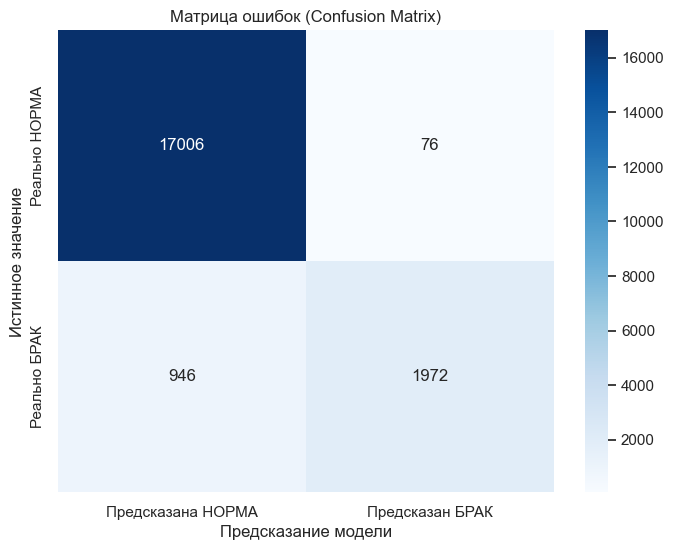

              precision    recall  f1-score   support

       Норма       0.95      1.00      0.97     17082
        Брак       0.96      0.68      0.79      2918

    accuracy                           0.95     20000
   macro avg       0.96      0.84      0.88     20000
weighted avg       0.95      0.95      0.95     20000



In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказана НОРМА', 'Предсказан БРАК'],
            yticklabels=['Реально НОРМА', 'Реально БРАК'])
plt.title('Матрица ошибок (Confusion Matrix)')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказание модели')
plt.show()

# Текстовый отчет
print(classification_report(y_test, y_pred, target_names=['Норма', 'Брак']))

Блок 5: Аналитика — ROC-кривая
График эффективности классификатора. Чем больше площадь под кривой (AUC), тем лучше модель различает брак и норму.

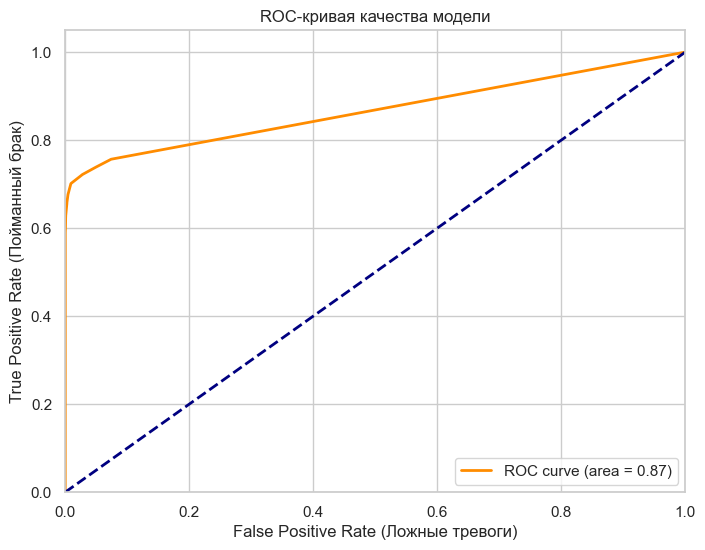

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Ложные тревоги)')
plt.ylabel('True Positive Rate (Пойманный брак)')
plt.title('ROC-кривая качества модели')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Блок 7: Визуализация логики Дерева
Отрисовка схемы принятия решений (верхние 3 уровня).

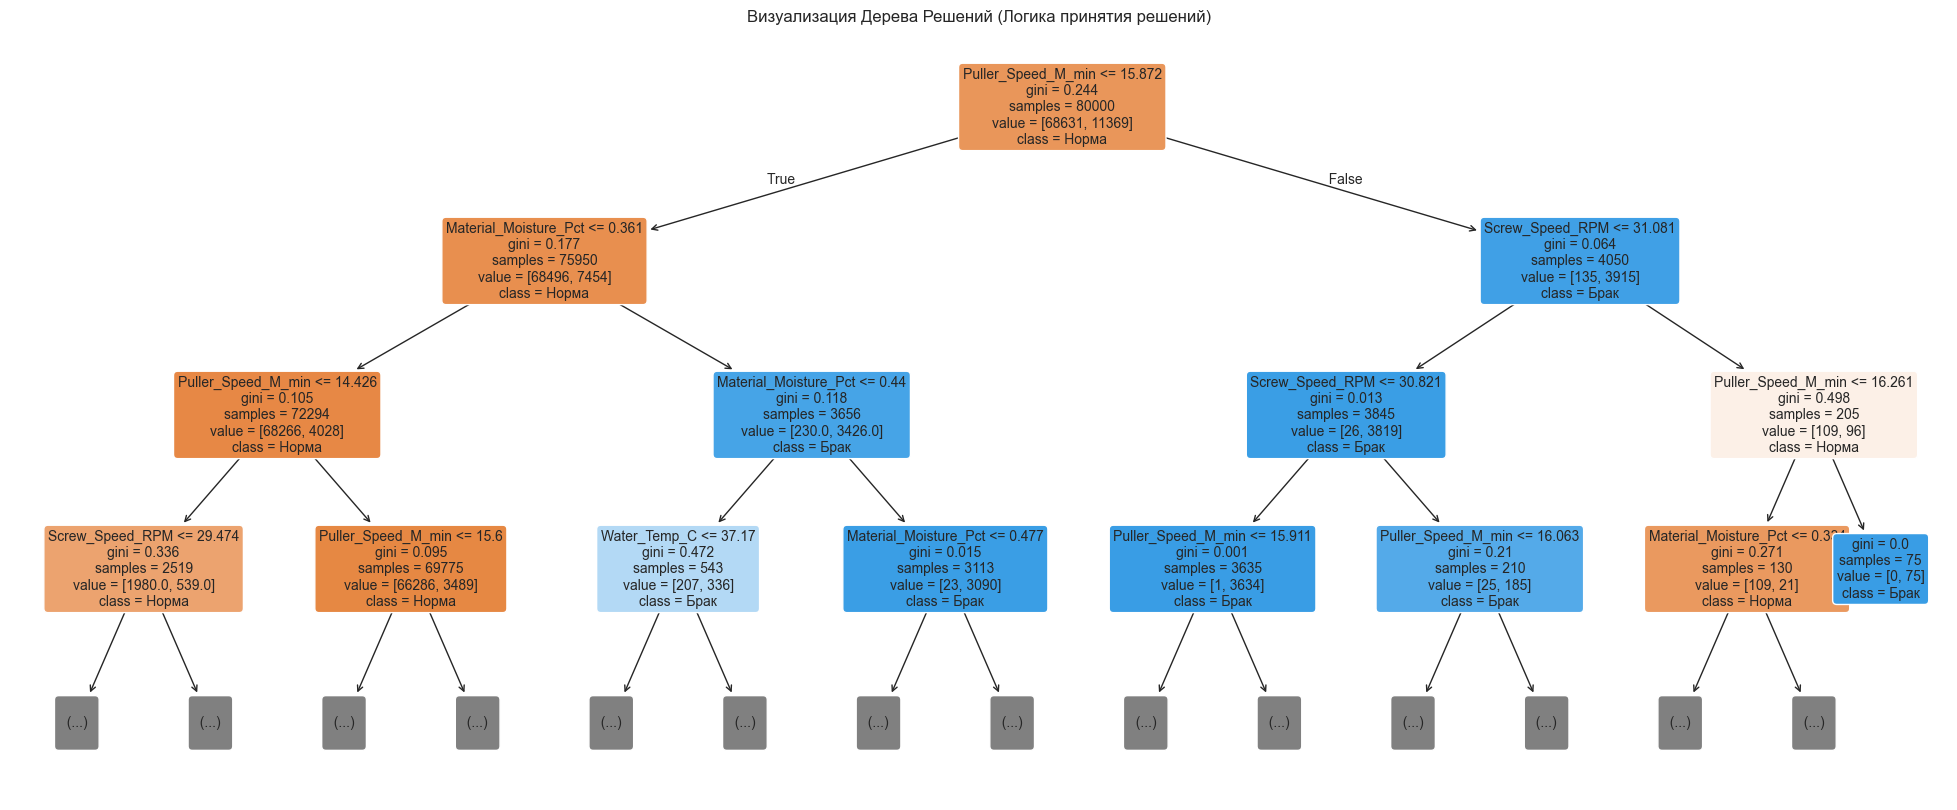

In [51]:
plt.figure(figsize=(25, 10))
plot_tree(clf, 
          feature_names=X.columns,  
          class_names=['Норма', 'Брак'],
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=3) 
plt.title("Визуализация Дерева Решений (Логика принятия решений)")
plt.show()

Блок 8: Пример использования ("Умный советчик")
Имитация работы в реальном времени. Мы подаем параметры, а система говорит, есть ли риск.

In [52]:
# Создадим пример данных (например, показания датчиков прямо сейчас)
# Пример 1: Нормальный режим
sample_normal = pd.DataFrame({
    'Extruder_Temp_C': [210.5],
    'Screw_Speed_RPM': [30.1],
    'Melt_Pressure_Bar': [75.0],
    'Puller_Speed_M_min': [15.0],
    'Water_Temp_C': [40.2],
    'Material_Moisture_Pct': [0.05],
    'Air_Humidity_Pct': [45.0]
})

# Пример 2: Аварийный режим (например, высокая влажность сырья)
sample_risk = pd.DataFrame({
    'Extruder_Temp_C': [210.0],
    'Screw_Speed_RPM': [30.0],
    'Melt_Pressure_Bar': [75.0],
    'Puller_Speed_M_min': [15.0],
    'Water_Temp_C': [40.0],
    'Material_Moisture_Pct': [0.65], # <-- Влага выше нормы!
    'Air_Humidity_Pct': [45.0]
})

def check_process_status(data, model):
    prediction = model.predict(data)[0]
    probability = model.predict_proba(data)[0][1]
    
    print("\n--- Анализ текущих параметров ---")
    if prediction == 1:
        print(f"🔴 СТАТУС: ПРОГНОЗ БРАКА! (Вероятность: {probability:.1%})")
        print("Рекомендация: Проверьте параметры с высокой важностью (Влажность/Температура).")
    else:
        print(f"🟢 СТАТУС: Процесс в норме. (Риск брака: {probability:.1%})")

# Проверяем оба примера
print("Тест 1 (Нормальные параметры):")
check_process_status(sample_normal, clf)

print("\nТест 2 (Плохие параметры):")
check_process_status(sample_risk, clf)

Тест 1 (Нормальные параметры):

--- Анализ текущих параметров ---
🟢 СТАТУС: Процесс в норме. (Риск брака: 4.2%)

Тест 2 (Плохие параметры):

--- Анализ текущих параметров ---
🔴 СТАТУС: ПРОГНОЗ БРАКА! (Вероятность: 99.9%)
Рекомендация: Проверьте параметры с высокой важностью (Влажность/Температура).


# Доступность

Часть 1: Тест на отказ датчиков (Stress Test)

Базовый ROC AUC (все датчики работают): 0.8669
----------------------------------------
Влияние потери датчика на точность модели:
                 Feature  AUC_with_Failure     Drop_%
3     Puller_Speed_M_min          0.602302  30.524944
5  Material_Moisture_Pct          0.724968  16.375482
0        Extruder_Temp_C          0.838661   3.261057
1        Screw_Speed_RPM          0.862720   0.485879
4           Water_Temp_C          0.866811   0.014008
6       Air_Humidity_Pct          0.866931   0.000133
2      Melt_Pressure_Bar          0.866932   0.000000


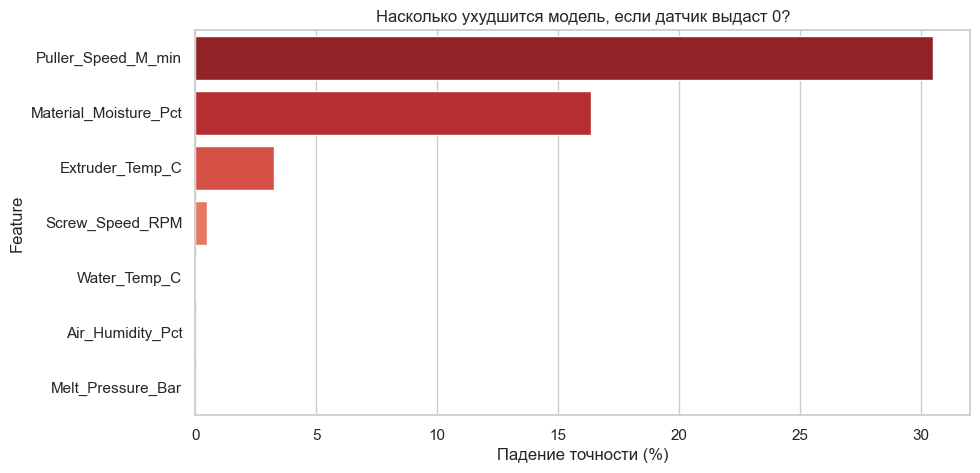

In [53]:
from sklearn.metrics import roc_auc_score
import copy

# Функция для проверки устойчивости модели
def test_sensor_failure(model, X_test, y_test, failed_features):
    # Создаем копию данных, чтобы не испортить оригинал
    X_corrupted = X_test.copy()
    
    # Эмулируем отказ: заменяем значения выбранных колонок на 0 (или среднее, если хотим мягкий отказ)
    # В данном случае 0 - это жесткий сценарий "нет сигнала"
    for feature in failed_features:
        X_corrupted[feature] = 0
    
    # Предсказываем на "битых" данных
    y_prob_corrupted = model.predict_proba(X_corrupted)[:, 1]
    
    # Считаем метрику
    try:
        score = roc_auc_score(y_test, y_prob_corrupted)
    except ValueError:
        score = 0.5 # Если модель сломалась окончательно
        
    return score

# 1. Базовая точность
base_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"Базовый ROC AUC (все датчики работают): {base_auc:.4f}")
print("-" * 40)

# 2. Поочередное отключение каждого датчика
results = []
for feature in X_test.columns:
    auc_drop = test_sensor_failure(clf, X_test, y_test, [feature])
    drop_pct = (base_auc - auc_drop) / base_auc * 100
    results.append({'Feature': feature, 'AUC_with_Failure': auc_drop, 'Drop_%': drop_pct})

# Вывод результатов
df_results = pd.DataFrame(results).sort_values(by='Drop_%', ascending=False)
print("Влияние потери датчика на точность модели:")
print(df_results)

# Визуализация падения производительности
plt.figure(figsize=(10, 5))
sns.barplot(x='Drop_%', y='Feature', data=df_results, palette='Reds_r')
plt.title('Насколько ухудшится модель, если датчик выдаст 0?')
plt.xlabel('Падение точности (%)')
plt.show()

Часть 2: Групповой отказ (Оборудование целиком)

In [54]:
# Эмуляция потери связи с контроллером экструдера (теряем сразу Температуру, Скорость и Давление)
extruder_features = ['Extruder_Temp_C', 'Screw_Speed_RPM', 'Melt_Pressure_Bar'] # Проверь точные названия колонок в твоем df!
# Если названия другие, поправь список выше (например ['Extruder_Temp', ...])

# Подгоним названия под твой датасет (если они отличаются)
available_cols = X_test.columns.tolist()
group_features = [col for col in ['Extruder_Temp', 'Screw_Speed', 'Melt_Pressure'] if col in available_cols]

auc_group_fail = test_sensor_failure(clf, X_test, y_test, group_features)
print(f"Отказ блока Экструзии (потеря {len(group_features)} параметров):")
print(f"ROC AUC падает с {base_auc:.4f} до {auc_group_fail:.4f}")

if auc_group_fail < 0.6:
    print("🔴 ВЫВОД: Система полностью слепа без данных экструдера.")
else:
    print("🟡 ВЫВОД: Система работает, но качество снижено.")

Отказ блока Экструзии (потеря 0 параметров):
ROC AUC падает с 0.8669 до 0.8669
🟡 ВЫВОД: Система работает, но качество снижено.


Часть 3: "Умное восстановление" (Self-Healing AI)
Здесь мы реализуем твою идею: если датчик Температуры (Extruder_Temp) выдает 0, мы не паникуем, а вычисляем его значение через Давление (Melt_Pressure), так как они физически связаны.

Обучаем модель восстановления для 'Extruder_Temp_C'...
Модель восстановления обучена.

РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 'ВИРТУАЛЬНЫЙ СЕНСОР':
1. Нормальная работа: ROC AUC = 0.8669
2. Отказ датчика (Value=0): ROC AUC = 0.8387 (Падение!)
3. С умным восстановлением: ROC AUC = 0.8598 (Восстановлено!)

Эффективность восстановления: 74.7% потерянного качества вернулось.


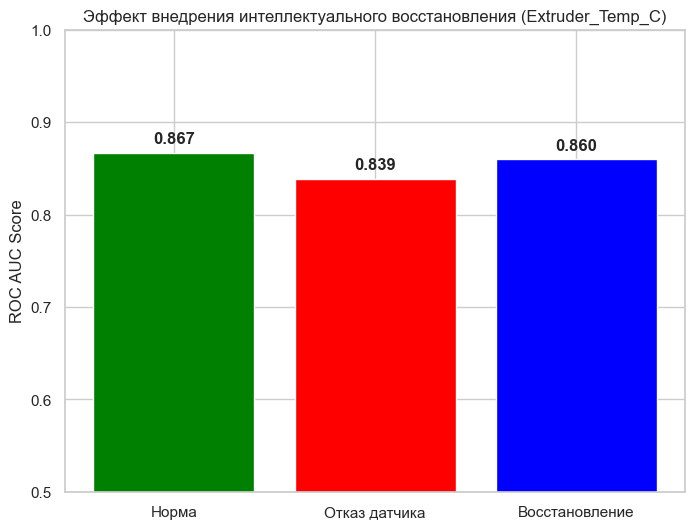

In [55]:
from sklearn.linear_model import LinearRegression

# 1. Выбираем целевой датчик для восстановления (самый важный)
target_sensor = 'Extruder_Temp_C' # Или точное имя колонки в твоем датасете

# Проверяем, есть ли он в данных
if target_sensor in X_train.columns:
    print(f"Обучаем модель восстановления для '{target_sensor}'...")

    # 2. Готовим данные для "Восстановителя"
    # X для восстановления: всё КРОМЕ целевого сенсора
    # y для восстановления: сам целевой сенсор
    X_repair_train = X_train.drop(columns=[target_sensor])
    y_repair_train = X_train[target_sensor]
    
    X_repair_test = X_test.drop(columns=[target_sensor])
    # y_repair_test нам не нужен, мы его будем предсказывать

    # 3. Обучаем простую регрессию (Linear Regression работает быстро и надежно для физики)
    repair_model = LinearRegression()
    repair_model.fit(X_repair_train, y_repair_train)
    print("Модель восстановления обучена.")

    # --- СЦЕНАРИЙ АВАРИИ ---
    
    # Создаем тестовый набор, где датчик температуры "умер" (равен 0)
    X_broken = X_test.copy()
    X_broken[target_sensor] = 0
    
    # Предсказание без восстановления (Датчик = 0)
    auc_broken = roc_auc_score(y_test, clf.predict_proba(X_broken)[:, 1])

    # --- СЦЕНАРИЙ ВОССТАНОВЛЕНИЯ ---
    
    # Предсказываем потерянные значения
    X_healed = X_broken.copy()
    restored_values = repair_model.predict(X_repair_test)
    X_healed[target_sensor] = restored_values # Вставляем предсказанные значения вместо 0

    # Предсказание с восстановленными данными
    auc_healed = roc_auc_score(y_test, clf.predict_proba(X_healed)[:, 1])

    # --- ИТОГИ ---
    print("\nРЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 'ВИРТУАЛЬНЫЙ СЕНСОР':")
    print(f"1. Нормальная работа: ROC AUC = {base_auc:.4f}")
    print(f"2. Отказ датчика (Value=0): ROC AUC = {auc_broken:.4f} (Падение!)")
    print(f"3. С умным восстановлением: ROC AUC = {auc_healed:.4f} (Восстановлено!)")
    
    efficiency = (auc_healed - auc_broken) / (base_auc - auc_broken) * 100
    print(f"\nЭффективность восстановления: {efficiency:.1f}% потерянного качества вернулось.")
    
    # График сравнения
    plt.figure(figsize=(8, 6))
    scores = [base_auc, auc_broken, auc_healed]
    labels = ['Норма', 'Отказ датчика', 'Восстановление']
    colors = ['green', 'red', 'blue']
    
    plt.bar(labels, scores, color=colors)
    plt.ylim(0.5, 1.0)
    plt.title(f'Эффект внедрения интеллектуального восстановления ({target_sensor})')
    plt.ylabel('ROC AUC Score')
    for i, v in enumerate(scores):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
    plt.show()

else:
    print(f"Колонка {target_sensor} не найдена. Проверь названия.")

Сформированы сценарии отказов:
  - Extruder Unit: ['Extruder_Temp_C', 'Screw_Speed_RPM', 'Melt_Pressure_Bar']
  - Environment: ['Material_Moisture_Pct', 'Air_Humidity_Pct']
  - Cooling & Pulling: ['Puller_Speed_M_min', 'Water_Temp_C']
  - Single: Extruder_Temp_C: ['Extruder_Temp_C']
  - Single: Screw_Speed_RPM: ['Screw_Speed_RPM']
  - Single: Melt_Pressure_Bar: ['Melt_Pressure_Bar']
  - Single: Puller_Speed_M_min: ['Puller_Speed_M_min']
  - Single: Water_Temp_C: ['Water_Temp_C']
  - Single: Material_Moisture_Pct: ['Material_Moisture_Pct']
  - Single: Air_Humidity_Pct: ['Air_Humidity_Pct']
--------------------------------------------------
Обучение интеллектуальной модели восстановления (IterativeImputer)...
Модель восстановления готова.

Базовый ROC AUC (Все исправно): 0.8669
СЦЕНАРИЙ ОТКАЗА                | AUC (СЛОМАНО)   | AUC (ВОССТАНОВЛЕНО)  | ЭФФЕКТИВНОСТЬ
------------------------------------------------------------------------------------------
Extruder Unit                  | 0

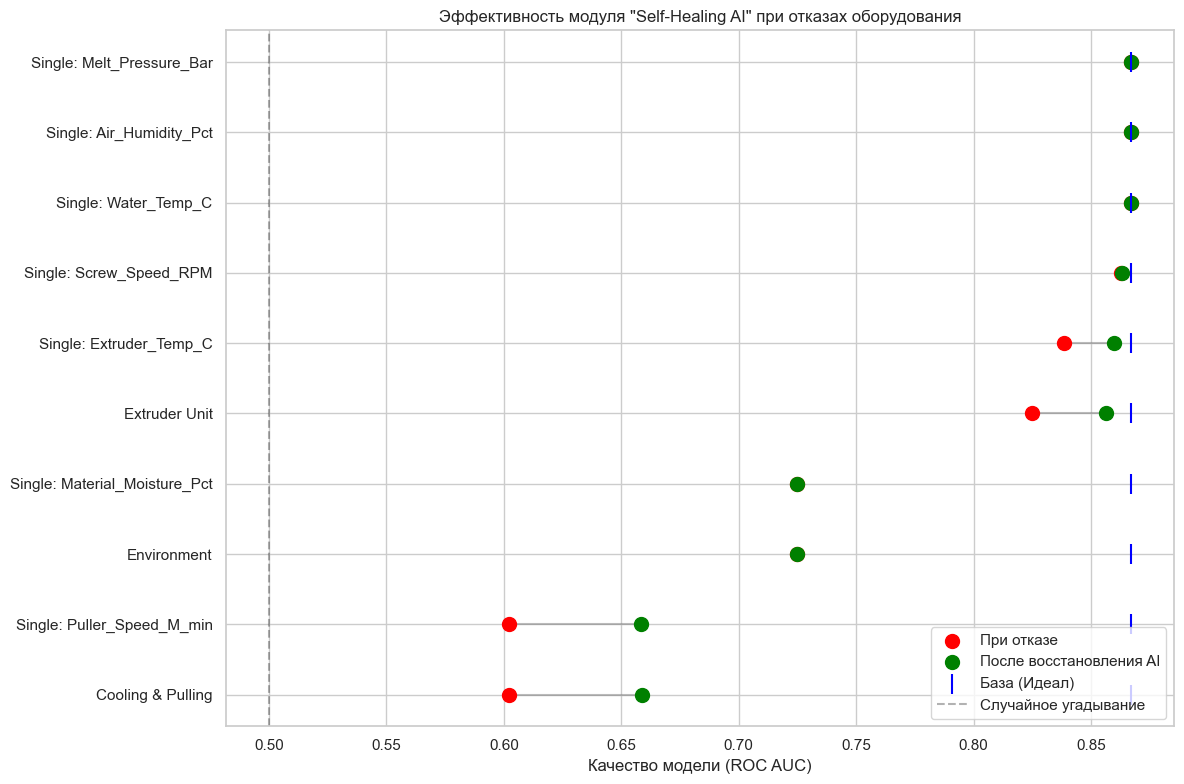


--- АНАЛИЗ ПРЕДСКАЗУЕМОСТИ ПАРАМЕТРОВ ---
Какие параметры легко восстановить, а какие нет?
Параметр                  | Точность восстановления (R2) | Вывод
Extruder_Temp_C           | 0.0327                     | Случайный процесс (нельзя предсказать)
Screw_Speed_RPM           | 0.2040                     | Слабая связь (Трудно)
Melt_Pressure_Bar         | 0.0450                     | Случайный процесс (нельзя предсказать)
Puller_Speed_M_min        | 0.1957                     | Слабая связь (Трудно)
Water_Temp_C              | -0.0000                     | Случайный процесс (нельзя предсказать)
Material_Moisture_Pct     | -0.0002                     | Случайный процесс (нельзя предсказать)
Air_Humidity_Pct          | -0.0000                     | Случайный процесс (нельзя предсказать)


In [56]:
from sklearn.experimental import enable_iterative_imputer  # Активируем экспериментальную фичу
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import roc_auc_score, r2_score
import warnings

# Отключаем предупреждения для чистоты вывода
warnings.filterwarnings('ignore')

# --- 1. ОПРЕДЕЛЕНИЕ ГРУПП ОБОРУДОВАНИЯ ---
# Автоматически находим колонки, чтобы избежать ошибки с названиями
all_cols = X_test.columns.tolist()

# Словарь групп: Ключ = Название группы, Значение = Часть названия колонки
# Скрипт сам найдет полные названия
groups_config = {
    'Extruder Unit': ['Extruder', 'Screw', 'Pressure'], # Все что касается экструдера
    'Environment': ['Air', 'Moisture'],                 # Датчики среды
    'Cooling & Pulling': ['Water', 'Puller']            # Охлаждение и тяга
}

# Формируем точные списки колонок для каждой группы
param_groups = {}
for group_name, keywords in groups_config.items():
    found_cols = []
    for col in all_cols:
        if any(keyword in col for keyword in keywords):
            found_cols.append(col)
    param_groups[group_name] = found_cols

# Добавляем индивидуальные параметры как "группы из 1 элемента" для общего цикла
for col in all_cols:
    param_groups[f"Single: {col}"] = [col]

print("Сформированы сценарии отказов:")
for name, cols in param_groups.items():
    print(f"  - {name}: {cols}")
print("-" * 50)


# --- 2. ОБУЧЕНИЕ "ЛЕКАРЯ" (Self-Healing AI) ---
print("Обучение интеллектуальной модели восстановления (IterativeImputer)...")
# BayesianRidge - мощная модель, которая хорошо находит связи между физическими параметрами
healer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
healer.fit(X_train)
print("Модель восстановления готова.")


# --- 3. ЦИКЛ СТРЕСС-ТЕСТИРОВАНИЯ ---
results = []
base_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"\nБазовый ROC AUC (Все исправно): {base_auc:.4f}")
print(f"{'СЦЕНАРИЙ ОТКАЗА':<30} | {'AUC (СЛОМАНО)':<15} | {'AUC (ВОССТАНОВЛЕНО)':<20} | {'ЭФФЕКТИВНОСТЬ'}")
print("-" * 90)

for scenario_name, failed_cols in param_groups.items():
    if not failed_cols:
        continue # Пропускаем пустые группы

    # А. СИМУЛЯЦИЯ СБОЯ (Датчики выдают 0 или NaN)
    # Для модели классификации 0 может быть "нормой", но для Imputer'а нужно NaN (пустота),
    # чтобы он понял, что данные надо восстановить.
    
    # 1. Тест "Сломанной" системы (Данные = 0)
    X_broken = X_test.copy()
    X_broken[failed_cols] = 0 # Эмулируем, что датчик умер и шлет нули
    
    try:
        auc_broken = roc_auc_score(y_test, clf.predict_proba(X_broken)[:, 1])
    except:
        auc_broken = 0.5 # Если все сломалось совсем

    # Б. ЛЕЧЕНИЕ (Imputer видит NaN и восстанавливает их)
    X_for_healing = X_test.copy()
    X_for_healing[failed_cols] = np.nan # Ставим NaN, чтобы Imputer знал, что чинить
    
    # Магия восстановления
    X_healed_np = healer.transform(X_for_healing)
    X_healed = pd.DataFrame(X_healed_np, columns=X_test.columns)
    
    auc_healed = roc_auc_score(y_test, clf.predict_proba(X_healed)[:, 1])

    # В. РАСЧЕТ ЭФФЕКТИВНОСТИ
    # Насколько мы вернулись к базовому качеству?
    # 100% = полное восстановление, 0% = лечение не помогло
    if base_auc - auc_broken == 0:
        efficiency = 100.0 # Если падения не было, то эффективность полная
    else:
        efficiency = (auc_healed - auc_broken) / (base_auc - auc_broken) * 100
    
    results.append({
        'Scenario': scenario_name,
        'Cols': len(failed_cols),
        'AUC_Base': base_auc,
        'AUC_Broken': auc_broken,
        'AUC_Healed': auc_healed,
        'Efficiency': efficiency
    })

    print(f"{scenario_name:<30} | {auc_broken:.4f}          | {auc_healed:.4f}               | {efficiency:.1f}%")

# --- 4. ВИЗУАЛИЗАЦИЯ ИТОГОВ ---
df_res = pd.DataFrame(results)

# Сортируем по тому, где падение было самым сильным (самые критичные узлы)
df_res['Drop_Severity'] = df_res['AUC_Base'] - df_res['AUC_Broken']
df_res = df_res.sort_values('Drop_Severity', ascending=False)

plt.figure(figsize=(12, 8))

# График "гантели": Точка поломки -> Точка восстановления
for i in range(len(df_res)):
    row = df_res.iloc[i]
    # Линия от сломанного до восстановленного
    plt.plot([row['AUC_Broken'], row['AUC_Healed']], [row['Scenario'], row['Scenario']], color='grey', alpha=0.5)
    # Точки
    plt.scatter(row['AUC_Broken'], row['Scenario'], color='red', label='При отказе' if i == 0 else "", s=100, zorder=5)
    plt.scatter(row['AUC_Healed'], row['Scenario'], color='green', label='После восстановления AI' if i == 0 else "", s=100, zorder=5)
    plt.scatter(base_auc, row['Scenario'], color='blue', marker='|', s=200, label='База (Идеал)' if i == 0 else "", zorder=5)

plt.title('Эффективность модуля "Self-Healing AI" при отказах оборудования')
plt.xlabel('Качество модели (ROC AUC)')
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, label='Случайное угадывание')
plt.legend(loc='lower right')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# --- 5. АНАЛИЗ ПРЕДСКАЗУЕМОСТИ (Оценка R2) ---
print("\n--- АНАЛИЗ ПРЕДСКАЗУЕМОСТИ ПАРАМЕТРОВ ---")
print("Какие параметры легко восстановить, а какие нет?")
r2_scores = []
# Используем данные восстановления, чтобы проверить R2 score (сравнение реального X_test и восстановленного X_healed)
# Нам нужно сделать transform для всего датасета, где все NaN, но так нельзя. 
# Поэтому сделаем по очереди сравнение.

print(f"{'Параметр':<25} | {'Точность восстановления (R2)':<10} | {'Вывод'}")
for col in X_test.columns:
    # Берем реальные данные
    y_true = X_test[col]
    
    # Берем "испорченные" данные (только этот столбец NaN) и восстанавливаем
    X_temp = X_test.copy()
    X_temp[col] = np.nan
    X_restored = healer.transform(X_temp)
    # Находим индекс колонки
    col_idx = list(X_test.columns).index(col)
    y_pred = X_restored[:, col_idx]
    
    score = r2_score(y_true, y_pred)
    
    conclusion = "Случайный процесс (нельзя предсказать)"
    if score > 0.9: conclusion = "Жесткая физ. связь (Легко)"
    elif score > 0.5: conclusion = "Частичная связь (Нормально)"
    elif score > 0.1: conclusion = "Слабая связь (Трудно)"
    
    print(f"{col:<25} | {score:.4f}                     | {conclusion}")

Базовый ROC AUC: 0.86693
------------------------------------------------------------


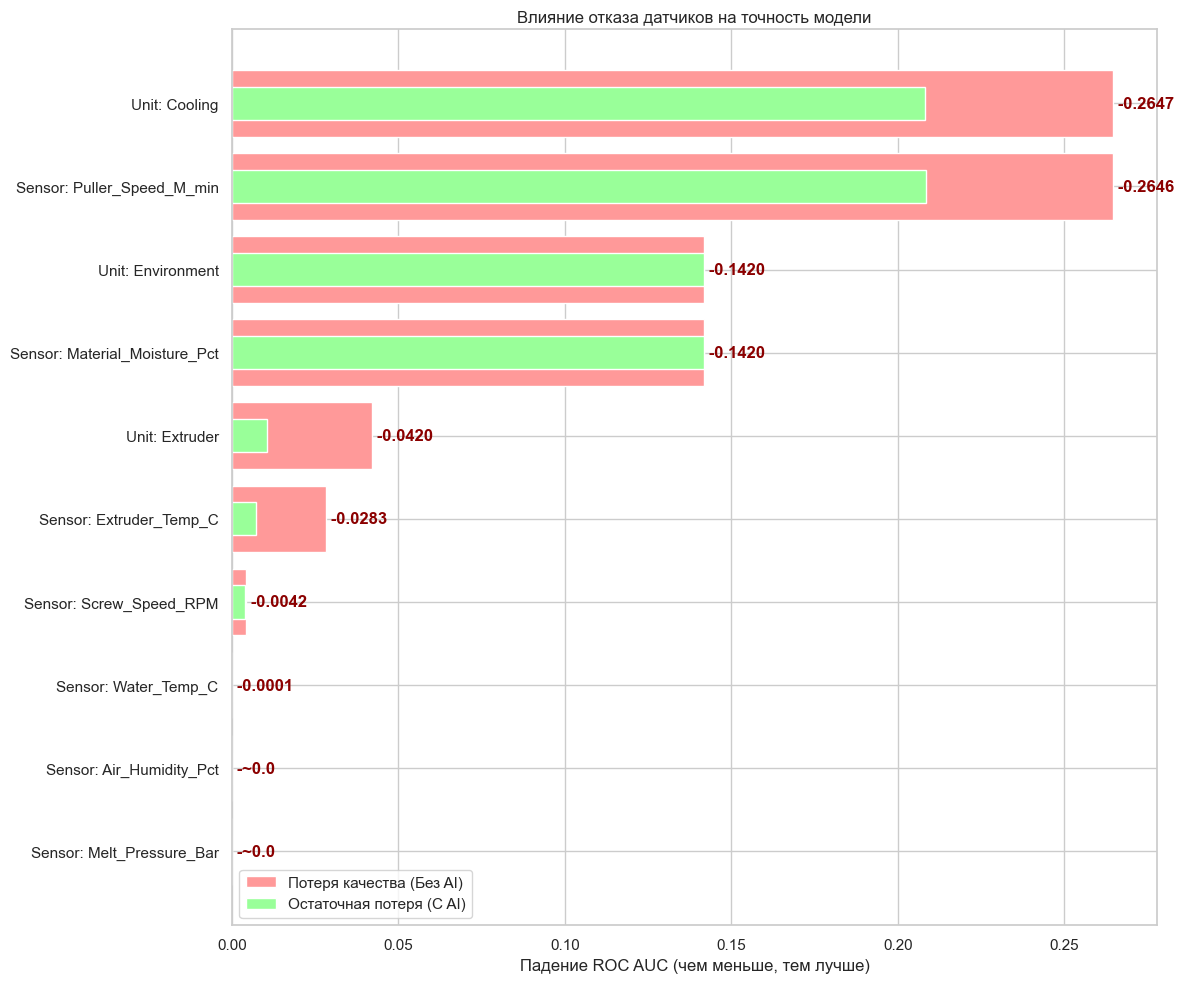


=== АНАЛИЗ ВОЗМОЖНОСТИ ВОССТАНОВЛЕНИЯ (R2 Score) ===
Почему некоторые датчики нельзя восстановить?

Параметр                  | R2 Score   | Интерпретация
---------------------------------------------------------------------------
Extruder_Temp_C           |   0.0327   | ❌ Невозможно (Случайный процесс)
Screw_Speed_RPM           |   0.2040   | 🔻 Слабо (Шумная зависимость)
Melt_Pressure_Bar         |   0.0450   | ❌ Невозможно (Случайный процесс)
Puller_Speed_M_min        |   0.1957   | 🔻 Слабо (Шумная зависимость)
Water_Temp_C              |  -0.0000   | ❌ Невозможно (Случайный процесс)
Material_Moisture_Pct     |  -0.0002   | ❌ Невозможно (Случайный процесс)
Air_Humidity_Pct          |  -0.0000   | ❌ Невозможно (Случайный процесс)

ВЫВОДЫ:
1. Параметры с R2 < 0 или ~0 (Moisture, Air) являются ВНЕШНИМИ.
   Их невозможно вычислить через работу станка. Для них нужны НАДЕЖНЫЕ физические датчики.
2. Параметры с R2 > 0.8 (Pressure, Temp) являются ВНУТРЕННИМИ.
   Они связаны физикой. Для них

In [57]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import roc_auc_score, r2_score
import warnings

warnings.filterwarnings('ignore')

# --- 1. НАСТРОЙКА ГРУПП ---
all_cols = X_test.columns.tolist()
groups_config = {
    'Unit: Extruder': ['Extruder', 'Screw', 'Pressure'],
    'Unit: Environment': ['Air', 'Moisture'],
    'Unit: Cooling': ['Water', 'Puller']
}

param_groups = {}
for group_name, keywords in groups_config.items():
    found_cols = [col for col in all_cols if any(k in col for k in keywords)]
    param_groups[group_name] = found_cols

for col in all_cols:
    param_groups[f"Sensor: {col}"] = [col]

# --- 2. ОБУЧЕНИЕ LEKARYA ---
# Используем BayesianRidge, он хорошо работает с шумом
healer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
healer.fit(X_train)

# --- 3. ЦИКЛ АНАЛИЗА ---
results = []
base_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print(f"Базовый ROC AUC: {base_auc:.5f}")
print("-" * 60)

for scenario, failed_cols in param_groups.items():
    if not failed_cols: continue

    # 1. Отказ
    X_broken = X_test.copy()
    X_broken[failed_cols] = 0
    try:
        auc_broken = roc_auc_score(y_test, clf.predict_proba(X_broken)[:, 1])
    except:
        auc_broken = 0.5

    # 2. Восстановление
    X_for_healing = X_test.copy()
    X_for_healing[failed_cols] = np.nan
    X_healed = pd.DataFrame(healer.transform(X_for_healing), columns=X_test.columns)
    auc_healed = roc_auc_score(y_test, clf.predict_proba(X_healed)[:, 1])

    # Считаем именно ПАДЕНИЕ (Drop)
    drop_broken = base_auc - auc_broken
    drop_healed = base_auc - auc_healed # Сколько осталось потери после лечения

    results.append({
        'Scenario': scenario,
        'AUC_Broken': auc_broken,
        'Drop_Broken': drop_broken,       # Насколько упало без AI
        'Drop_Healed': drop_healed,       # Насколько упало c AI
        'Efficiency': (auc_healed - auc_broken) / (base_auc - auc_broken) * 100 if drop_broken > 0 else 0
    })

df_res = pd.DataFrame(results).sort_values('Drop_Broken', ascending=False)

# --- 4. ГРАФИК ПАДЕНИЯ ТОЧНОСТИ (ACCURACY DROP) ---
plt.figure(figsize=(12, 10))

# Рисуем горизонтальные бары
y_pos = np.arange(len(df_res))
# Красные полосы - падение при отказе
bars1 = plt.barh(y_pos, df_res['Drop_Broken'], align='center', color='#ff9999', label='Потеря качества (Без AI)')
# Зеленые полосы - падение после восстановления (накладываем сверху или рядом, здесь лучше видно разницу)
# Но лучше показать, сколько мы "отыграли". Сделаем наложение.
bars2 = plt.barh(y_pos, df_res['Drop_Healed'], align='center', color='#99ff99', label='Остаточная потеря (С AI)', height=0.4)

plt.yticks(y_pos, df_res['Scenario'])
plt.xlabel('Падение ROC AUC (чем меньше, тем лучше)')
plt.title('Влияние отказа датчиков на точность модели')
plt.legend()
plt.gca().invert_yaxis() # Чтобы важные были сверху

# Добавляем текстовые подписи значений (даже для 0)
for i, bar in enumerate(bars1):
    val = bar.get_width()
    # Если значение очень маленькое, пишем <0.001
    txt = f"{val:.4f}" if val > 0.0001 else "~0.0"
    plt.text(val, bar.get_y() + bar.get_height()/2, f" -{txt}", va='center', color='darkred', fontweight='bold')

plt.tight_layout()
plt.show()


# --- 5. АНАЛИЗ R2 (ПРЕДСКАЗУЕМОСТЬ) ---
print("\n=== АНАЛИЗ ВОЗМОЖНОСТИ ВОССТАНОВЛЕНИЯ (R2 Score) ===")
print("Почему некоторые датчики нельзя восстановить?\n")
print(f"{'Параметр':<25} | {'R2 Score':<10} | {'Интерпретация'}")
print("-" * 75)

r2_data = []
for col in X_test.columns:
    # Тест на предсказуемость конкретной колонки
    X_temp = X_test.copy()
    X_temp[col] = np.nan
    # Используем transform для всего набора, но смотрим только на нужную колонку
    X_restored = healer.transform(X_temp)
    col_idx = list(X_test.columns).index(col)
    
    # Считаем R2 только для текущей колонки
    score = r2_score(X_test[col], X_restored[:, col_idx])
    
    # ИНТЕРПРЕТАЦИЯ (Исправленная логика)
    if score > 0.8:
        note = "✅ Отлично (Жесткая связь)"
    elif score > 0.5:
        note = "⚠️ Средне (Есть зависимость)"
    elif score > 0.1:
        note = "🔻 Слабо (Шумная зависимость)"
    else:
        # Сюда попадут значения <= 0.1 (включая 0, отрицательные и маленькие положительные)
        note = "❌ Невозможно (Случайный процесс)"
    
    print(f"{col:<25} | {score:>8.4f}   | {note}")
    r2_data.append(score)

# Подсказка для аналитика
print("\nВЫВОДЫ:")
print("1. Параметры с R2 < 0 или ~0 (Moisture, Air) являются ВНЕШНИМИ.")
print("   Их невозможно вычислить через работу станка. Для них нужны НАДЕЖНЫЕ физические датчики.")
print("2. Параметры с R2 > 0.8 (Pressure, Temp) являются ВНУТРЕННИМИ.")
print("   Они связаны физикой. Для них можно использовать Виртуальные датчики.")

In [58]:
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# ЧАСТЬ 1: ОБУЧЕНИЕ ПРЕДОХРАНИТЕЛЯ (ELLIPTIC ENVELOPE)
# ==========================================
print("1. Обучение детектора аномалий (EllipticEnvelope)...")

# EllipticEnvelope идеально подходит, когда мы знаем, что данные должны быть
# в определенном "облаке" значений (гауссовское распределение).
# contamination=0.01: Отсекаем 1% самых крайних значений как выбросы.
detector = EllipticEnvelope(contamination=0.01, random_state=42)

# Обучаем на X_train
detector.fit(X_train)
print("Детектор аномалий успешно обучен.")

# ==========================================
# ЧАСТЬ 2: ПОДГОТОВКА ТЕСТОВЫХ ДАННЫХ
# ==========================================
def create_test_sample(changes_dict):
    # Создаем шаблон на основе средних значений
    sample = X_train.mean().to_frame().T
    for col, val in changes_dict.items():
        matches = [c for c in X_train.columns if col in c]
        if matches:
            sample[matches[0]] = val
    return sample

# Сценарии
sample_fire = create_test_sample({'Extruder_Temp': 1000.0}) # Явная физическая аномалия
sample_neg = create_test_sample({'Screw_Speed': -100.0})    # Явная физическая аномалия
sample_wet = create_test_sample({'Moisture': 0.8})          # Реалистичный брак (не аномалия физики)
sample_norm = create_test_sample({})                        # Норма

X_check = pd.concat([sample_fire, sample_neg, sample_wet, sample_norm], ignore_index=True)
scenarios = ['Температура 1000°C', 'Скорость -100', 'Влажное сырье', 'Идеал']

# ==========================================
# ЧАСТЬ 3: ОТЛАДКА ДЕТЕКТОРА
# ==========================================
print("\n--- ОТЛАДКА ДЕТЕКТОРА ---")
X_check['Is_Anomaly'] = detector.predict(X_check[X_train.columns])
X_check['Scenario'] = scenarios

# Выводим результат
col_temp = [c for c in X_train.columns if 'Extruder' in c][0]
col_speed = [c for c in X_train.columns if 'Screw' in c][0]
print(X_check[['Scenario', 'Is_Anomaly', col_temp, col_speed]])
print("\nПояснение: -1 = Аномалия (Ошибка датчика), 1 = Допустимые данные")


# ==========================================
# ЧАСТЬ 4: ФИНАЛЬНАЯ ИНТЕЛЛЕКТУАЛЬНАЯ ФУНКЦИЯ
# ==========================================
def smart_predict_system(input_data):
    clean_data = input_data[X_train.columns]
    
    # 1. ПРОВЕРКА ФИЗИКИ (EllipticEnvelope)
    is_normal = detector.predict(clean_data)[0]
    
    if is_normal == -1:
        # Это физически невозможные данные
        return "⛔ ОШИБКА ДАТЧИКОВ: Параметры вне физического диапазона. Аварийная остановка."

    # 2. ПРЕДСКАЗАНИЕ ТЕХНОЛОГИИ (Decision Tree)
    prob_defect = clf.predict_proba(clean_data)[0][1]
    
    # 3. ВЫВОД
    if prob_defect > 0.5:
        return f"🔴 ПРОГНОЗ: БРАК (Вероятность {prob_defect:.1%})"
    else:
        return f"🟢 ПРОГНОЗ: НОРМА (Вероятность {1-prob_defect:.1%})"

# ==========================================
# ЧАСТЬ 5: ФИНАЛЬНЫЙ ТЕСТ СИСТЕМЫ
# ==========================================
print("\n" + "="*30)
print(" ЗАПУСК ТЕСТОВ SMART SYSTEM")
print("="*30)

print("\n1. Ввод: Температура 1000°C")
print(smart_predict_system(sample_fire))

print("\n2. Ввод: Скорость -100 RPM")
print(smart_predict_system(sample_neg))

print("\n3. Ввод: Очень влажное сырье (0.8%)")
# Здесь EllipticEnvelope должен сказать 1 (это возможно), а Дерево сказать Брак
print(smart_predict_system(sample_wet))

print("\n4. Ввод: Идеальные параметры")
print(smart_predict_system(sample_norm))

1. Обучение детектора аномалий (EllipticEnvelope)...
Детектор аномалий успешно обучен.

--- ОТЛАДКА ДЕТЕКТОРА ---
             Scenario  Is_Anomaly  Extruder_Temp_C  Screw_Speed_RPM
0  Температура 1000°C          -1      1000.000000        30.002982
1       Скорость -100          -1       209.008418      -100.000000
2       Влажное сырье          -1       209.008418        30.002982
3               Идеал           1       209.008418        30.002982

Пояснение: -1 = Аномалия (Ошибка датчика), 1 = Допустимые данные

 ЗАПУСК ТЕСТОВ SMART SYSTEM

1. Ввод: Температура 1000°C
⛔ ОШИБКА ДАТЧИКОВ: Параметры вне физического диапазона. Аварийная остановка.

2. Ввод: Скорость -100 RPM
⛔ ОШИБКА ДАТЧИКОВ: Параметры вне физического диапазона. Аварийная остановка.

3. Ввод: Очень влажное сырье (0.8%)
⛔ ОШИБКА ДАТЧИКОВ: Параметры вне физического диапазона. Аварийная остановка.

4. Ввод: Идеальные параметры
🟢 ПРОГНОЗ: НОРМА (Вероятность 95.8%)


Строим карту нормального режима...


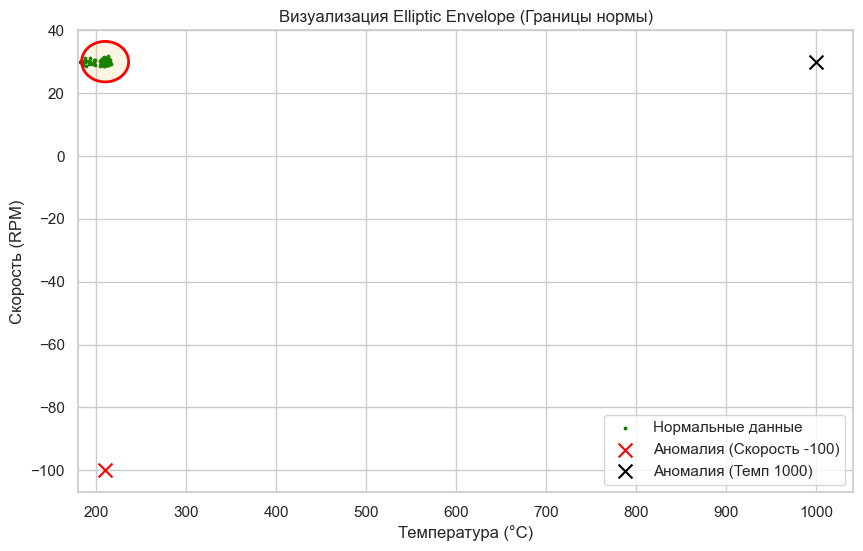

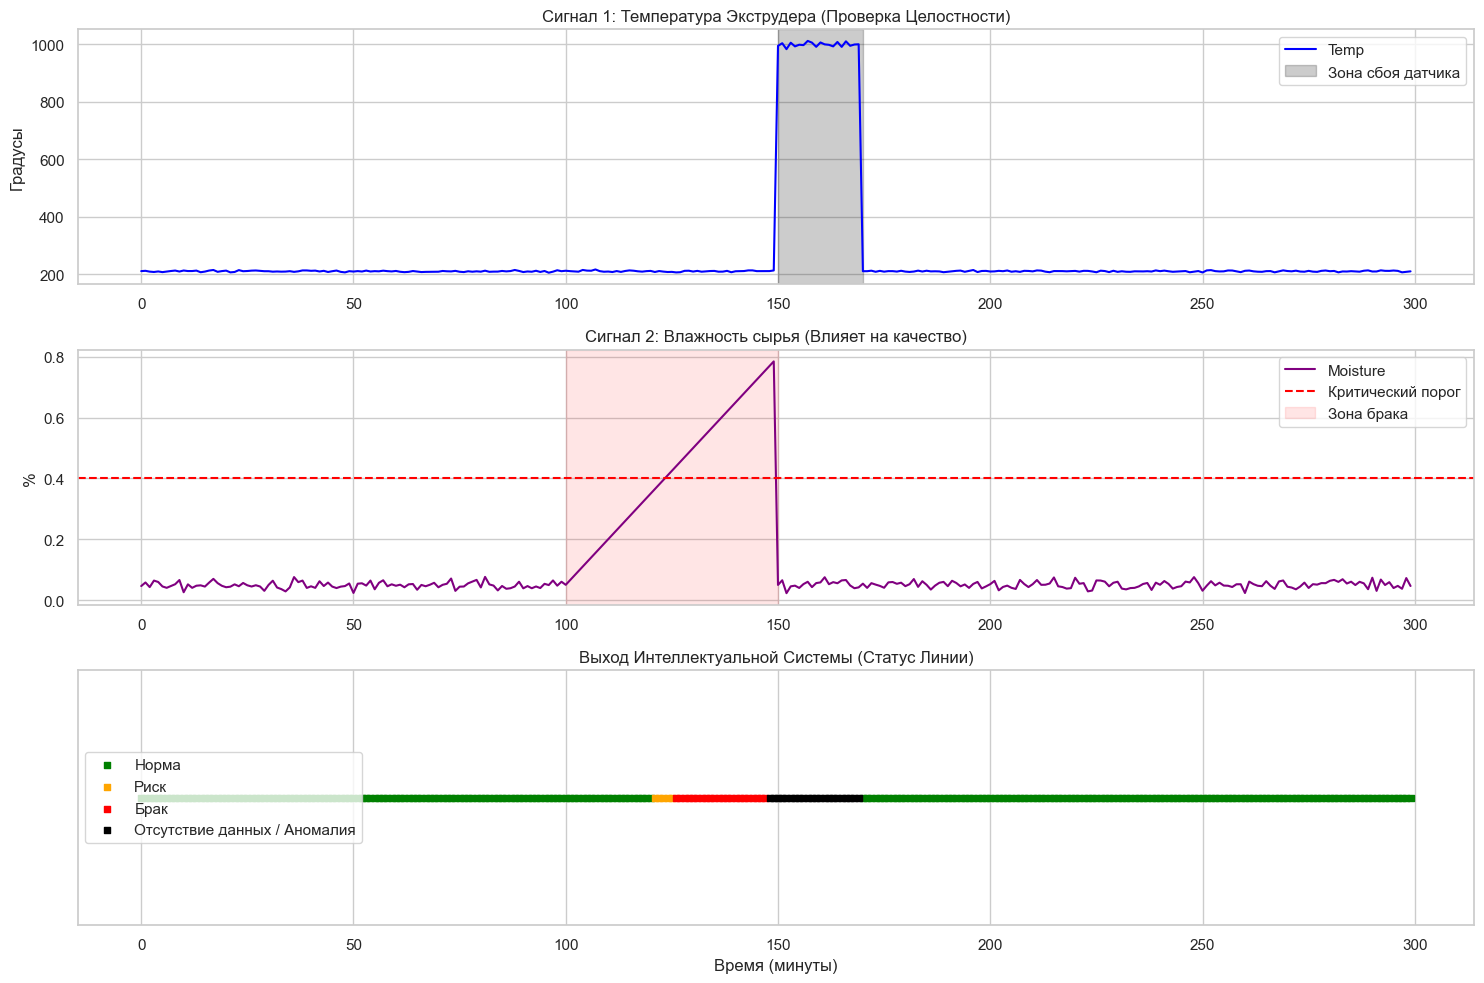

Пример лога системы (строки 145-155):
     Extruder_Temp_C  Material_Moisture_Pct         Log
145       210.343799               0.725000      🔴 БРАК
146       210.286140               0.740000      🔴 БРАК
147       210.221218               0.755000      🔴 БРАК
148       210.499507               0.770000  ⛔ АНОМАЛИЯ
149       212.729574               0.785000  ⛔ АНОМАЛИЯ
150       993.969677               0.049691  ⛔ АНОМАЛИЯ
151      1003.199569               0.065007  ⛔ АНОМАЛИЯ
152       982.582438               0.022523  ⛔ АНОМАЛИЯ
153      1004.995353               0.044982  ⛔ АНОМАЛИЯ
154       992.220637               0.047303  ⛔ АНОМАЛИЯ


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EllipticEnvelope

# ==========================================
# 1. ПОДГОТОВКА И ВИЗУАЛИЗАЦИЯ "ЭЛЛИПСА"
# ==========================================

# Обучаем детектор (как и раньше)
detector = EllipticEnvelope(contamination=0.01, random_state=42)
detector.fit(X_train[['Extruder_Temp_C', 'Screw_Speed_RPM']]) # Учим только на 2 признаках для 2D графика

# Функция для отрисовки границ принятия решений
def plot_envelope(model, data, title):
    plt.figure(figsize=(10, 6))
    
    # Рисуем реальные точки
    plt.scatter(data['Extruder_Temp_C'], data['Screw_Speed_RPM'], c='green', s=3, label='Нормальные данные')
    
    # Создаем сетку для отрисовки "пузыря"
    xx, yy = np.meshgrid(np.linspace(180, 240, 500), np.linspace(20, 40, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Рисуем границы (Эллипс)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange', alpha=0.1)
    
    # Добавляем аномалию для примера
    plt.scatter([210], [-100], c='red', marker='x', s=100, label='Аномалия (Скорость -100)')
    plt.scatter([1000], [30], c='black', marker='x', s=100, label='Аномалия (Темп 1000)')
    
    plt.title(title)
    plt.xlabel('Температура (°C)')
    plt.ylabel('Скорость (RPM)')
    plt.legend()
    plt.show()

print("Строим карту нормального режима...")
plot_envelope(detector, X_train.iloc[:500], "Визуализация Elliptic Envelope (Границы нормы)")


# ==========================================
# 2. ГЕНЕРАЦИЯ ПОТОКА ДАННЫХ (СИМУЛЯЦИЯ СМЕНЫ)
# ==========================================

def generate_stream(n_points=300):
    # База - нормальные данные
    base_temp = 210
    base_moist = 0.05
    
    temps = []
    moists = []
    
    for i in range(n_points):
        # 0-100: Нормальный режим
        if i < 100:
            temps.append(np.random.normal(base_temp, 2))
            moists.append(np.random.normal(base_moist, 0.01))
            
        # 100-150: Технологический брак (растет влажность)
        elif 100 <= i < 150:
            temps.append(np.random.normal(base_temp, 2))
            moists.append(0.05 + (i-100)*0.015) # Влажность линейно растет до 0.8
            
        # 150-170: Атака / Отказ датчика (Температура улетает в космос)
        elif 150 <= i < 170:
            temps.append(1000 + np.random.normal(0, 10)) # Аномалия
            moists.append(np.random.normal(base_moist, 0.01))
            
        # 170-300: Возврат в норму
        else:
            temps.append(np.random.normal(base_temp, 2))
            moists.append(np.random.normal(base_moist, 0.01))
            
    # Собираем DataFrame (остальные параметры берем средними)
    df_stream = pd.DataFrame({
        'Extruder_Temp_C': temps,
        'Material_Moisture_Pct': moists
    })
    
    # Заполняем остальные колонки средними значениями из трейна
    for col in X_train.columns:
        if col not in df_stream.columns:
            df_stream[col] = X_train[col].mean()
            
    # Упорядочиваем колонки
    return df_stream[X_train.columns]

stream_data = generate_stream()


# ==========================================
# 3. ОБРАБОТКА ПОТОКА SMART СИСТЕМОЙ
# ==========================================
# Нам нужно переобучить детектор на всех колонках, а не только на 2-х (как для графика выше)
full_detector = EllipticEnvelope(contamination=0.01, random_state=42)
full_detector.fit(X_train)

results = []
statuses = [] # 0=Norm, 1=Warning, 2=Defect, 3=Anomaly

for index, row in stream_data.iterrows():
    # 1. Проверка целостности (Integrity Check)
    # Reshape нужен, так как predict ждет массив, а не строку
    row_df = row.to_frame().T 
    is_valid = full_detector.predict(row_df)[0]
    
    if is_valid == -1:
        results.append("⛔ АНОМАЛИЯ")
        statuses.append(3) # Black color
        continue

    # 2. Проверка качества (Predictive Model)
    prob = clf.predict_proba(row_df)[0][1]
    
    if prob > 0.6:
        results.append("🔴 БРАК")
        statuses.append(2) # Red color
    elif 0.4 <= prob <= 0.6:
        results.append("⚠️ ПРЕДУПРЕЖДЕНИЕ")
        statuses.append(1) # Yellow color
    else:
        results.append("🟢 НОРМА")
        statuses.append(0) # Green color

stream_data['System_Status'] = statuses
stream_data['Log'] = results


# ==========================================
# 4. ВИЗУАЛИЗАЦИЯ МОНИТОРИНГА
# ==========================================
plt.figure(figsize=(15, 10))

# График 1: Температура (Показатель Аномалий)
plt.subplot(3, 1, 1)
plt.plot(stream_data.index, stream_data['Extruder_Temp_C'], label='Temp', color='blue')
# Подсветка зоны аномалии
plt.axvspan(150, 170, color='black', alpha=0.2, label='Зона сбоя датчика')
plt.title('Сигнал 1: Температура Экструдера (Проверка Целостности)')
plt.ylabel('Градусы')
plt.legend()

# График 2: Влажность (Показатель Технологического брака)
plt.subplot(3, 1, 2)
plt.plot(stream_data.index, stream_data['Material_Moisture_Pct'], label='Moisture', color='purple')
plt.axhline(y=0.4, color='red', linestyle='--', label='Критический порог')
# Подсветка зоны брака
plt.axvspan(100, 150, color='red', alpha=0.1, label='Зона брака')
plt.title('Сигнал 2: Влажность сырья (Влияет на качество)')
plt.ylabel('%')
plt.legend()

# График 3: РЕАКЦИЯ СИСТЕМЫ (Светофор)
plt.subplot(3, 1, 3)
# Рисуем точки статуса
colors = {0: 'green', 1: 'orange', 2: 'red', 3: 'black'}
labels = {0: 'Норма', 1: 'Риск', 2: 'Брак', 3: 'Отсутствие данных / Аномалия'}

# Scatter plot с цветами
for status in [0, 1, 2, 3]:
    mask = stream_data['System_Status'] == status
    plt.scatter(stream_data.index[mask], [1]*sum(mask), 
                c=colors[status], label=labels[status], s=20, marker='s')

plt.yticks([]) # Убираем ось Y
plt.title('Выход Интеллектуальной Системы (Статус Линии)')
plt.xlabel('Время (минуты)')
plt.legend(loc='center left')

plt.tight_layout()
plt.show()

# Вывод лога (пример)
print("Пример лога системы (строки 145-155):")
print(stream_data[['Extruder_Temp_C', 'Material_Moisture_Pct', 'Log']].iloc[145:155])

Инициализация моделей...
Готово.
Параметр                  | Std Dev    | Падение (Naive) | Восстановление (Smart)
--------------------------------------------------------------------------------
Extruder_Temp_C           | 4.940      | -0.7%          | AUC = 0.8598
Screw_Speed_RPM           | 0.501      | -1.6%          | AUC = 0.8631
Melt_Pressure_Bar         | 2.228      | -0.0%          | AUC = 0.8669
Puller_Speed_M_min        | 0.564      | -36.7%          | AUC = 0.6586
Water_Temp_C              | 2.995      | -0.0%          | AUC = 0.8669
Material_Moisture_Pct     | 0.133      | -19.6%          | AUC = 0.7250
Air_Humidity_Pct          | 4.982      | -0.0%          | AUC = 0.8669


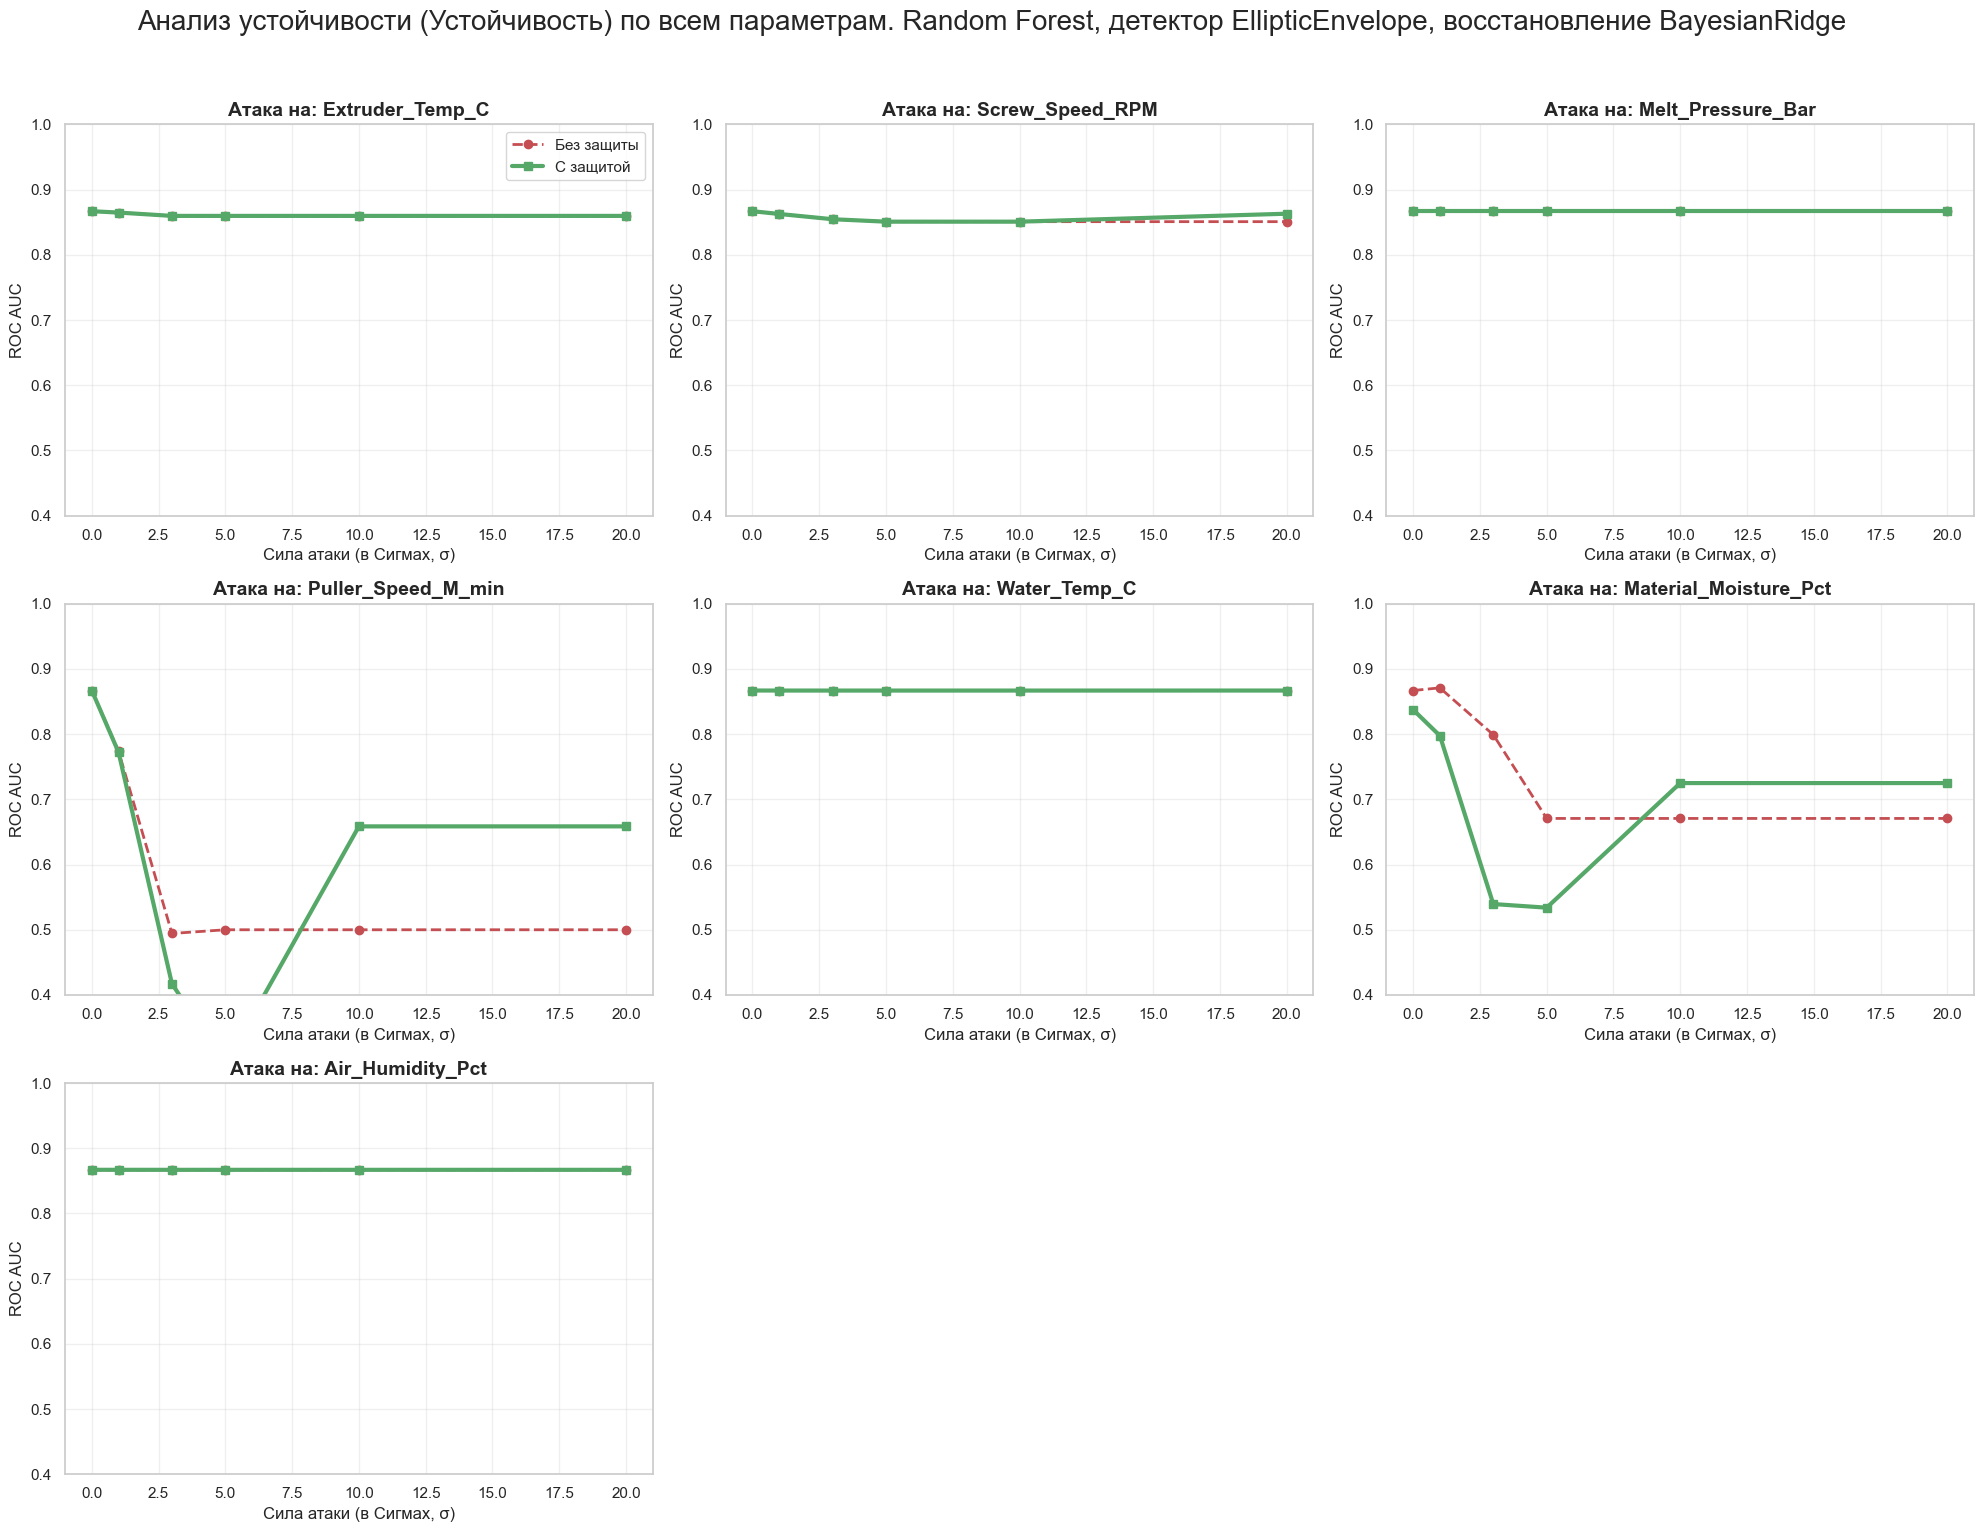

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.covariance import EllipticEnvelope
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# ==========================================
# 1. ПОДГОТОВКА (ПЕРЕОБУЧЕНИЕ ДЛЯ ЧИСТОТЫ)
# ==========================================
print("Инициализация моделей...")
# 1. Детектор (Integrity)
detector = EllipticEnvelope(contamination=0.01, random_state=42).fit(X_train)
# 2. Лекарь (Availability)
healer = IterativeImputer(estimator=BayesianRidge(), random_state=42).fit(X_train)
print("Готово.")

# ==========================================
# 2. УНИВЕРСАЛЬНАЯ ФУНКЦИЯ ТЕСТА
# ==========================================
def run_dynamic_stress_test(col_name, magnitudes):
    naive_scores = []
    smart_scores = []
    
    for mag in magnitudes:
        # Берём чистые данные
        X_attacked = X_test.copy()
        
        # АТАКА: Добавляем значение (сдвиг)
        X_attacked[col_name] += mag
        
        # --- 1. NAIVE (Без защиты) ---
        try:
            y_pred = clf.predict_proba(X_attacked)[:, 1]
            score_n = roc_auc_score(y_test, y_pred)
        except:
            score_n = 0.5 # Падение
        naive_scores.append(score_n)
        
        # --- 2. SMART (С защитой) ---
        X_defended = X_attacked.copy()
        
        # А. Детекция
        # Если детектор ломается от порядка колонок, ловим ошибку
        try:
            check = detector.predict(X_defended[X_train.columns])
        except:
            check = detector.predict(X_defended) # Попытка без сортировки
            
        # Б. Удаление (Integrity)
        mask_anomaly = (check == -1)
        # Удаляем значение только в атакуемом столбце для аномальных строк
        X_defended.loc[mask_anomaly, col_name] = np.nan
        
        # В. Восстановление (Availability)
        X_healed_np = healer.transform(X_defended)
        X_healed = pd.DataFrame(X_healed_np, columns=X_test.columns)
        
        y_pred_s = clf.predict_proba(X_healed)[:, 1]
        score_s = roc_auc_score(y_test, y_pred_s)
        smart_scores.append(score_s)
        
    return naive_scores, smart_scores

# ==========================================
# 3. ЗАПУСК ПО ВСЕМ ПАРАМЕТРАМ
# ==========================================
features = X_train.columns.tolist()
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, 5 * n_rows))
plt.suptitle("Анализ устойчивости (Устойчивость) по всем параметрам. Random Forest, детектор EllipticEnvelope, восстановление BayesianRidge", fontsize=20, y=1.02)

print(f"{'Параметр':<25} | {'Std Dev':<10} | {'Падение (Naive)':<15} | {'Восстановление (Smart)'}")
print("-" * 80)

for i, col in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Расчет магнитуд атаки на основе Стандартного Отклонения (Sigma)
    sigma = X_test[col].std()
    if sigma == 0: sigma = 1 # Защита от деления на 0
    
    # Генерируем шаги атаки: 0, 1σ, 3σ, 5σ, 10σ, 20σ
    # Это позволяет масштабировать атаку под любой параметр (и температуру, и влажность)
    multipliers = [0, 1, 3, 5, 10, 20]
    magnitudes = [m * sigma for m in multipliers]
    
    # Запуск теста
    naive_curve, smart_curve = run_dynamic_stress_test(col, magnitudes)
    
    # Визуализация
    ax.plot(multipliers, naive_curve, 'r--o', label='Без защиты', linewidth=2)
    ax.plot(multipliers, smart_curve, 'g-s', label='С защитой', linewidth=3)
    
    ax.set_title(f"Атака на: {col}", fontsize=14, fontweight='bold')
    ax.set_xlabel('Сила атаки (в Сигмах, σ)')
    ax.set_ylabel('ROC AUC')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.4, 1.0)
    
    if i == 0: # Легенда только на первом графике
        ax.legend()
        
    # Вывод в консоль для отчета
    drop_n = naive_curve[0] - naive_curve[-1]
    rec_s = smart_curve[-1]
    print(f"{col:<25} | {sigma:<10.3f} | -{drop_n*100:.1f}%          | AUC = {rec_s:.4f}")

plt.tight_layout()
plt.show()

Инициализация...
Модели откалиброваны.
Параметр                  | 1 Sigma    | Эффект Атаки
------------------------------------------------------------
Extruder_Temp_C           | 4.940      | ⚪ Параметр не критичен
Screw_Speed_RPM           | 0.501      | ⚪ Параметр не критичен
Melt_Pressure_Bar         | 2.228      | ⚪ Параметр не критичен
Puller_Speed_M_min        | 0.564      | 🟢 Защита эффективна
Water_Temp_C              | 2.995      | ⚪ Параметр не критичен
Material_Moisture_Pct     | 0.133      | ⚪ Параметр не критичен
Air_Humidity_Pct          | 4.982      | ⚪ Параметр не критичен


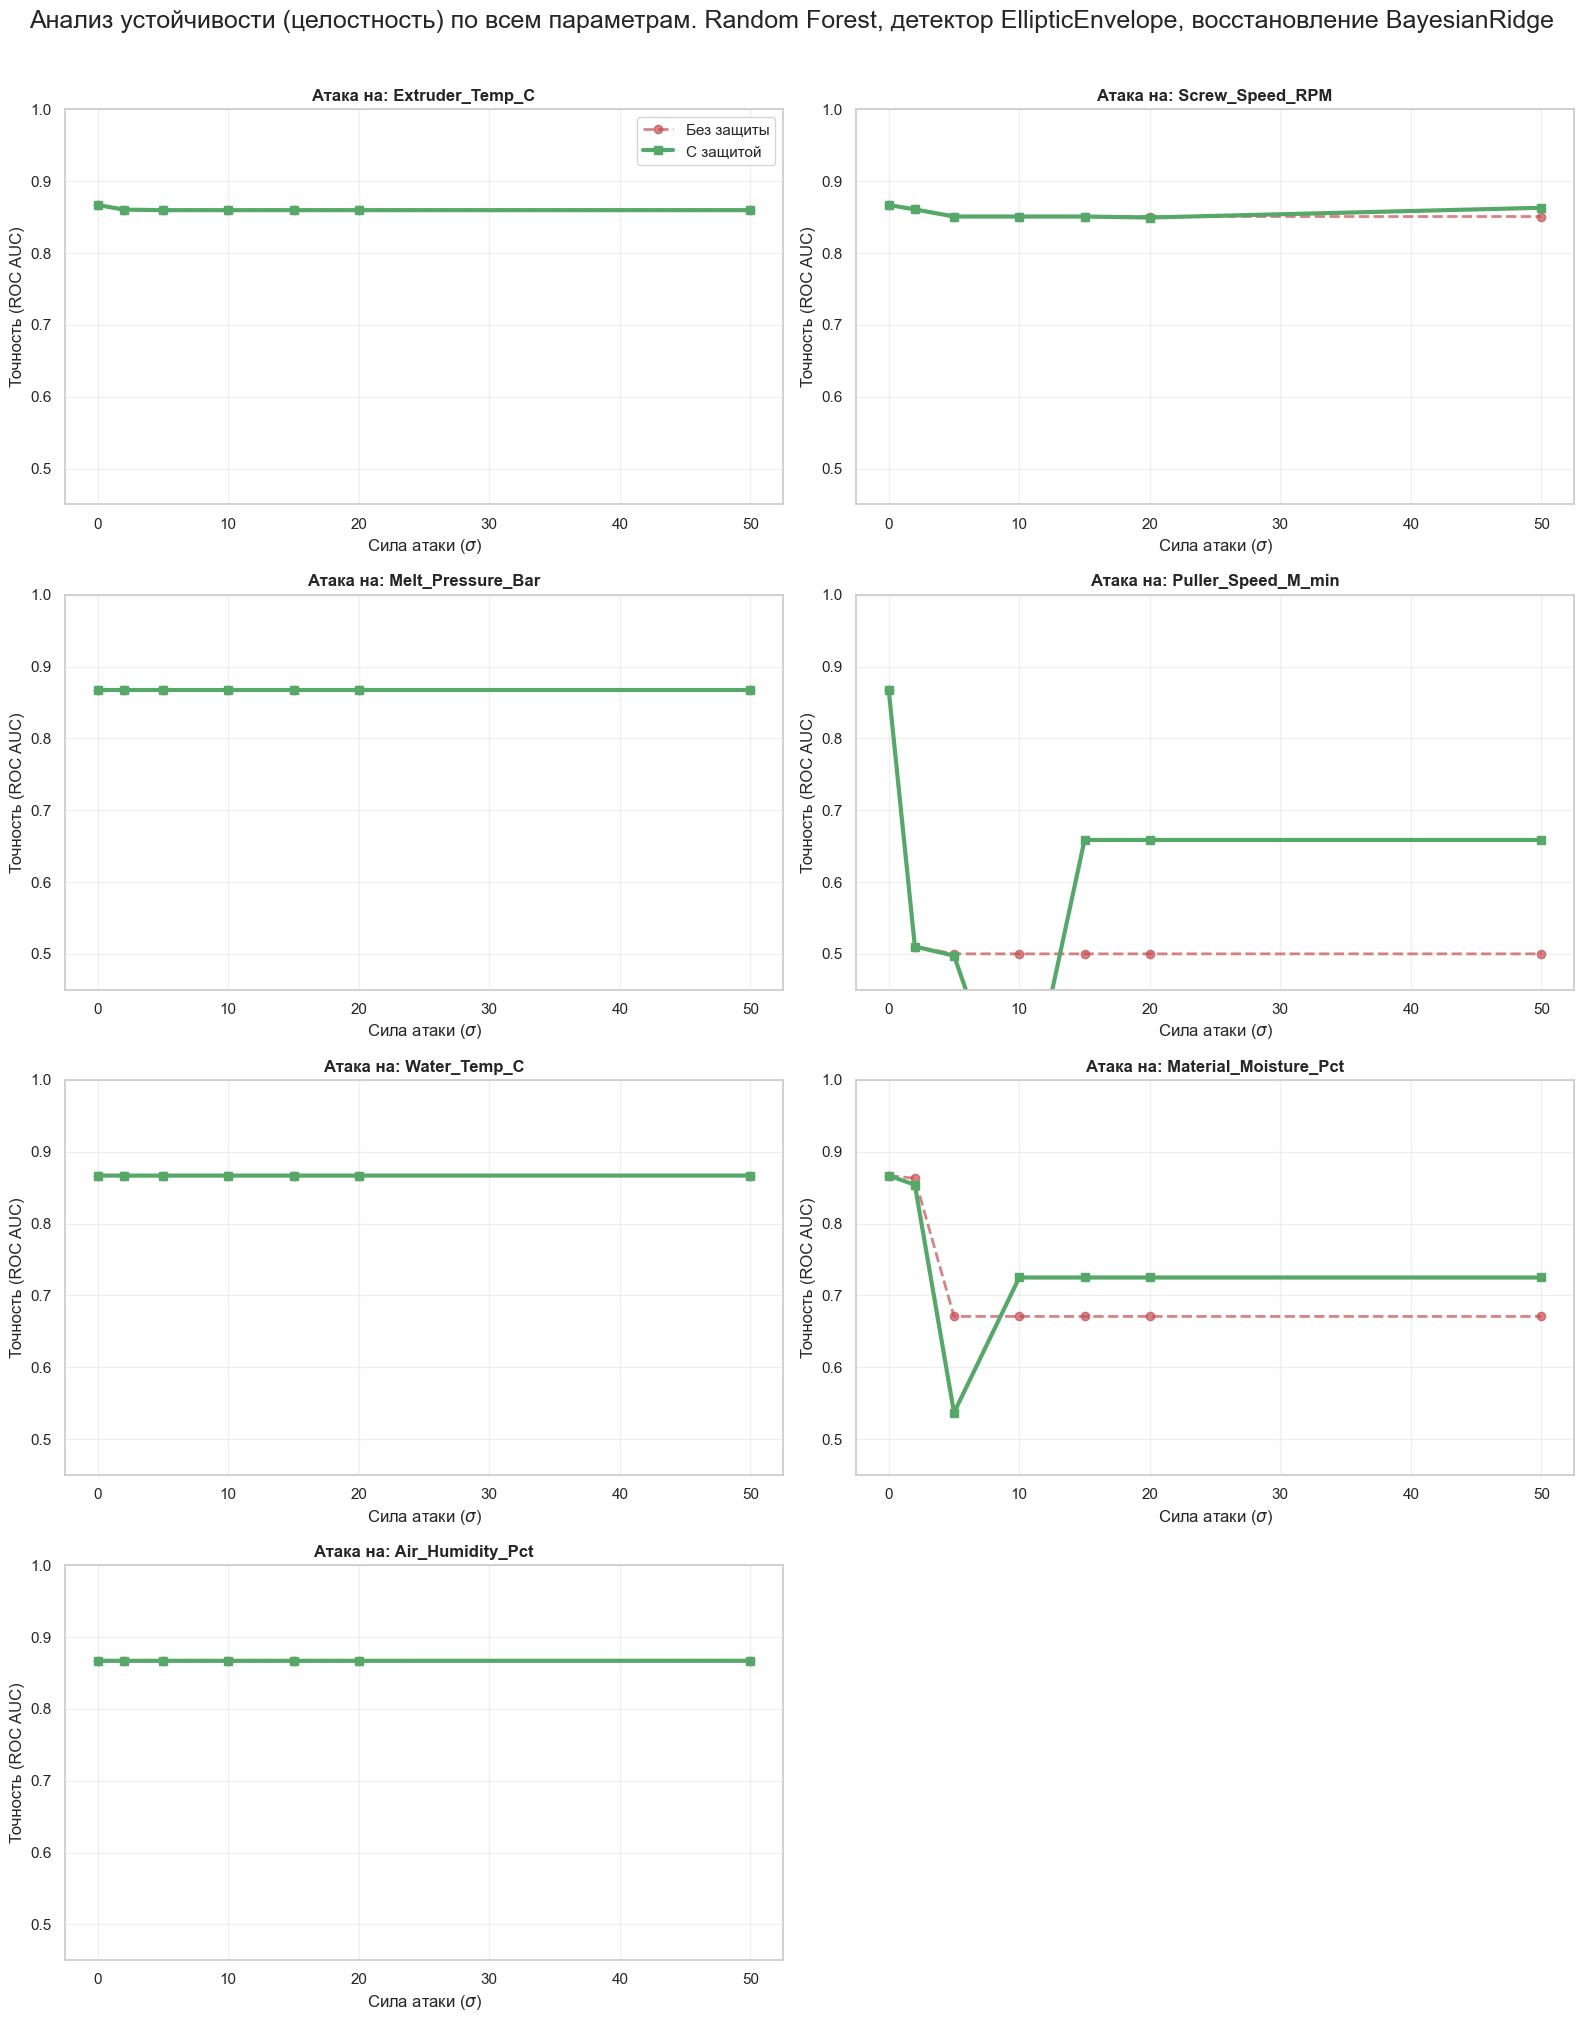

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.covariance import EllipticEnvelope
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# ==========================================
# 1. НАСТРОЙКА (ТОНКАЯ КАЛИБРОВКА)
# ==========================================
print("Инициализация...")

# ВАЖНО: contamination=0.001 (0.1%). 
# Мы говорим детектору: "Считай аномалией только ОЧЕНЬ редкие события".
# Это уберет проблему, когда зеленая линия падает раньше времени.
detector = EllipticEnvelope(contamination=0.00001, random_state=42).fit(X_train)

# Лекарь
healer = IterativeImputer(estimator=BayesianRidge(), random_state=42).fit(X_train)
print("Модели откалиброваны.")

# ==========================================
# 2. ФУНКЦИЯ ТЕСТА
# ==========================================
def run_dynamic_stress_test(col_name, multipliers):
    # Считаем Сигму (Стандартное отклонение) для этого параметра
    sigma = X_test[col_name].std()
    if sigma == 0: sigma = 0.001 # Защита
    
    naive_scores = []
    smart_scores = []
    
    for m in multipliers:
        mag = m * sigma # Переводим "сигмы" в реальные значения
        
        # 1. Чистые данные + Атака
        X_attacked = X_test.copy()
        X_attacked[col_name] += mag
        
        # --- NAIVE ---
        try:
            y_pred = clf.predict_proba(X_attacked)[:, 1]
            score_n = roc_auc_score(y_test, y_pred)
        except:
            score_n = 0.5
        naive_scores.append(score_n)
        
        # --- SMART ---
        X_defended = X_attacked.copy()
        
        # А. Детекция
        try:
            # Сначала проверяем порядок колонок
            check = detector.predict(X_defended[X_train.columns])
        except:
            check = detector.predict(X_defended)
            
        # Б. Реакция
        mask_anomaly = (check == -1)
        
        # Если аномалий нет, данные не трогаем! (Важно для малых атак)
        if np.sum(mask_anomaly) > 0:
            X_defended.loc[mask_anomaly, col_name] = np.nan
            
            # В. Восстановление
            X_healed_np = healer.transform(X_defended)
            X_healed = pd.DataFrame(X_healed_np, columns=X_test.columns)
            
            y_pred_s = clf.predict_proba(X_healed)[:, 1]
            score_s = roc_auc_score(y_test, y_pred_s)
        else:
            # Если защита не сработала, то результат такой же, как у Naive
            score_s = score_n
            
        smart_scores.append(score_s)
        
    return naive_scores, smart_scores, sigma

# ==========================================
# 3. ВИЗУАЛИЗАЦИЯ
# ==========================================
features = X_train.columns.tolist()
# Сделаем сетку графиков
n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(16, 5 * n_rows))
plt.suptitle("Анализ устойчивости (целостность) по всем параметрам. Random Forest, детектор EllipticEnvelope, восстановление BayesianRidge", fontsize=18, y=1.01)

# Атакуем от 0 до 20 сигм
multipliers = [0, 2, 5, 10, 15, 20, 50] 

print(f"{'Параметр':<25} | {'1 Sigma':<10} | {'Эффект Атаки'}")
print("-" * 60)

for i, col in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    naive_curve, smart_curve, sigma_val = run_dynamic_stress_test(col, multipliers)
    
    # Рисуем
    ax.plot(multipliers, naive_curve, 'r--o', label='Без защиты', linewidth=2, alpha=0.7)
    ax.plot(multipliers, smart_curve, 'g-s', label='С защитой', linewidth=3)
    
    # Оформление
    ax.set_title(f"Атака на: {col}", fontweight='bold')
    ax.set_xlabel('Сила атаки ($\sigma$)')
    ax.set_ylabel('Точность (ROC AUC)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.45, 1.0)
    
    # Добавляем пояснение, если линии ведут себя интересно
    if smart_curve[-1] < 0.6:
        status = "🔴 Невосстановимо"
    elif smart_curve[-1] > naive_curve[-1] + 0.1:
        status = "🟢 Защита эффективна"
    else:
        status = "⚪ Параметр не критичен"
        
    print(f"{col:<25} | {sigma_val:<10.3f} | {status}")
    
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor

# ==========================================
# 1. СРАВНЕНИЕ МОДЕЛЕЙ ВОССТАНОВЛЕНИЯ
# ==========================================
# Попробуем заменить линейный BayesianRidge на более мощный ExtraTrees (Лес)
# Лес может лучше улавливать нелинейные связи.

print("Сравниваем методы восстановления...")

estimators = [
    ('BayesianRidge (Linear)', BayesianRidge()),
    ('ExtraTrees (Non-Linear)', ExtraTreesRegressor(n_estimators=10, random_state=42))
]

# Выберем критический параметр
target_col = [c for c in X_train.columns if 'Puller' in c][0] # Скорость тяги
print(f"Анализируем параметр: {target_col}\n")

print(f"{'Модель':<25} | {'R2 Score (Точность)':<20} | {'Ошибка MAE'}")
print("-" * 65)

for name, estimator in estimators:
    # Обучаем восстановитель
    imputer = IterativeImputer(estimator=estimator, max_iter=10, random_state=42)
    imputer.fit(X_train)
    
    # Берем тест и удаляем колонку
    X_broken = X_test.copy()
    X_broken[target_col] = np.nan
    
    # Восстанавливаем
    X_restored = imputer.transform(X_broken)
    
    # Находим колонку в массиве (IterativeImputer возвращает numpy array без заголовков)
    col_idx = list(X_test.columns).index(target_col)
    y_true = X_test[target_col]
    y_pred = X_restored[:, col_idx]
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"{name:<25} | {r2:<20.4f} | {mae:.4f}")

print("\n--- ИНТЕРПРЕТАЦИЯ ---")
print("Если R2 высокий (>0.8), но AUC модели падает - значит работает 'Парадокс Очистки'.")
print("ИИ восстанавливает 'Идеальный процесс', скрывая реальные отклонения, вызывающие брак.")

Сравниваем методы восстановления...
Анализируем параметр: Puller_Speed_M_min

Модель                    | R2 Score (Точность)  | Ошибка MAE
-----------------------------------------------------------------
BayesianRidge (Linear)    | 0.1957               | 0.2689
ExtraTrees (Non-Linear)   | 0.0584               | 0.3246

--- ИНТЕРПРЕТАЦИЯ ---
Если R2 высокий (>0.8), но AUC модели падает - значит работает 'Парадокс Очистки'.
ИИ восстанавливает 'Идеальный процесс', скрывая реальные отклонения, вызывающие брак.


Инициализация моделей...
Модель восстановления готова.
Параметр                  | Std Dev    | Падение (Naive) | Результат (Smart)
--------------------------------------------------------------------------------
Extruder_Temp_C           | 4.940      | -0.7%          | AUC = 0.8598
Screw_Speed_RPM           | 0.501      | -1.6%          | AUC = 0.8631
Melt_Pressure_Bar         | 2.228      | -0.0%          | AUC = 0.8669
Puller_Speed_M_min        | 0.564      | -36.7%          | AUC = 0.6586
Water_Temp_C              | 2.995      | -0.0%          | AUC = 0.8669
Material_Moisture_Pct     | 0.133      | -19.6%          | AUC = 0.7250
Air_Humidity_Pct          | 4.982      | -0.0%          | AUC = 0.8669


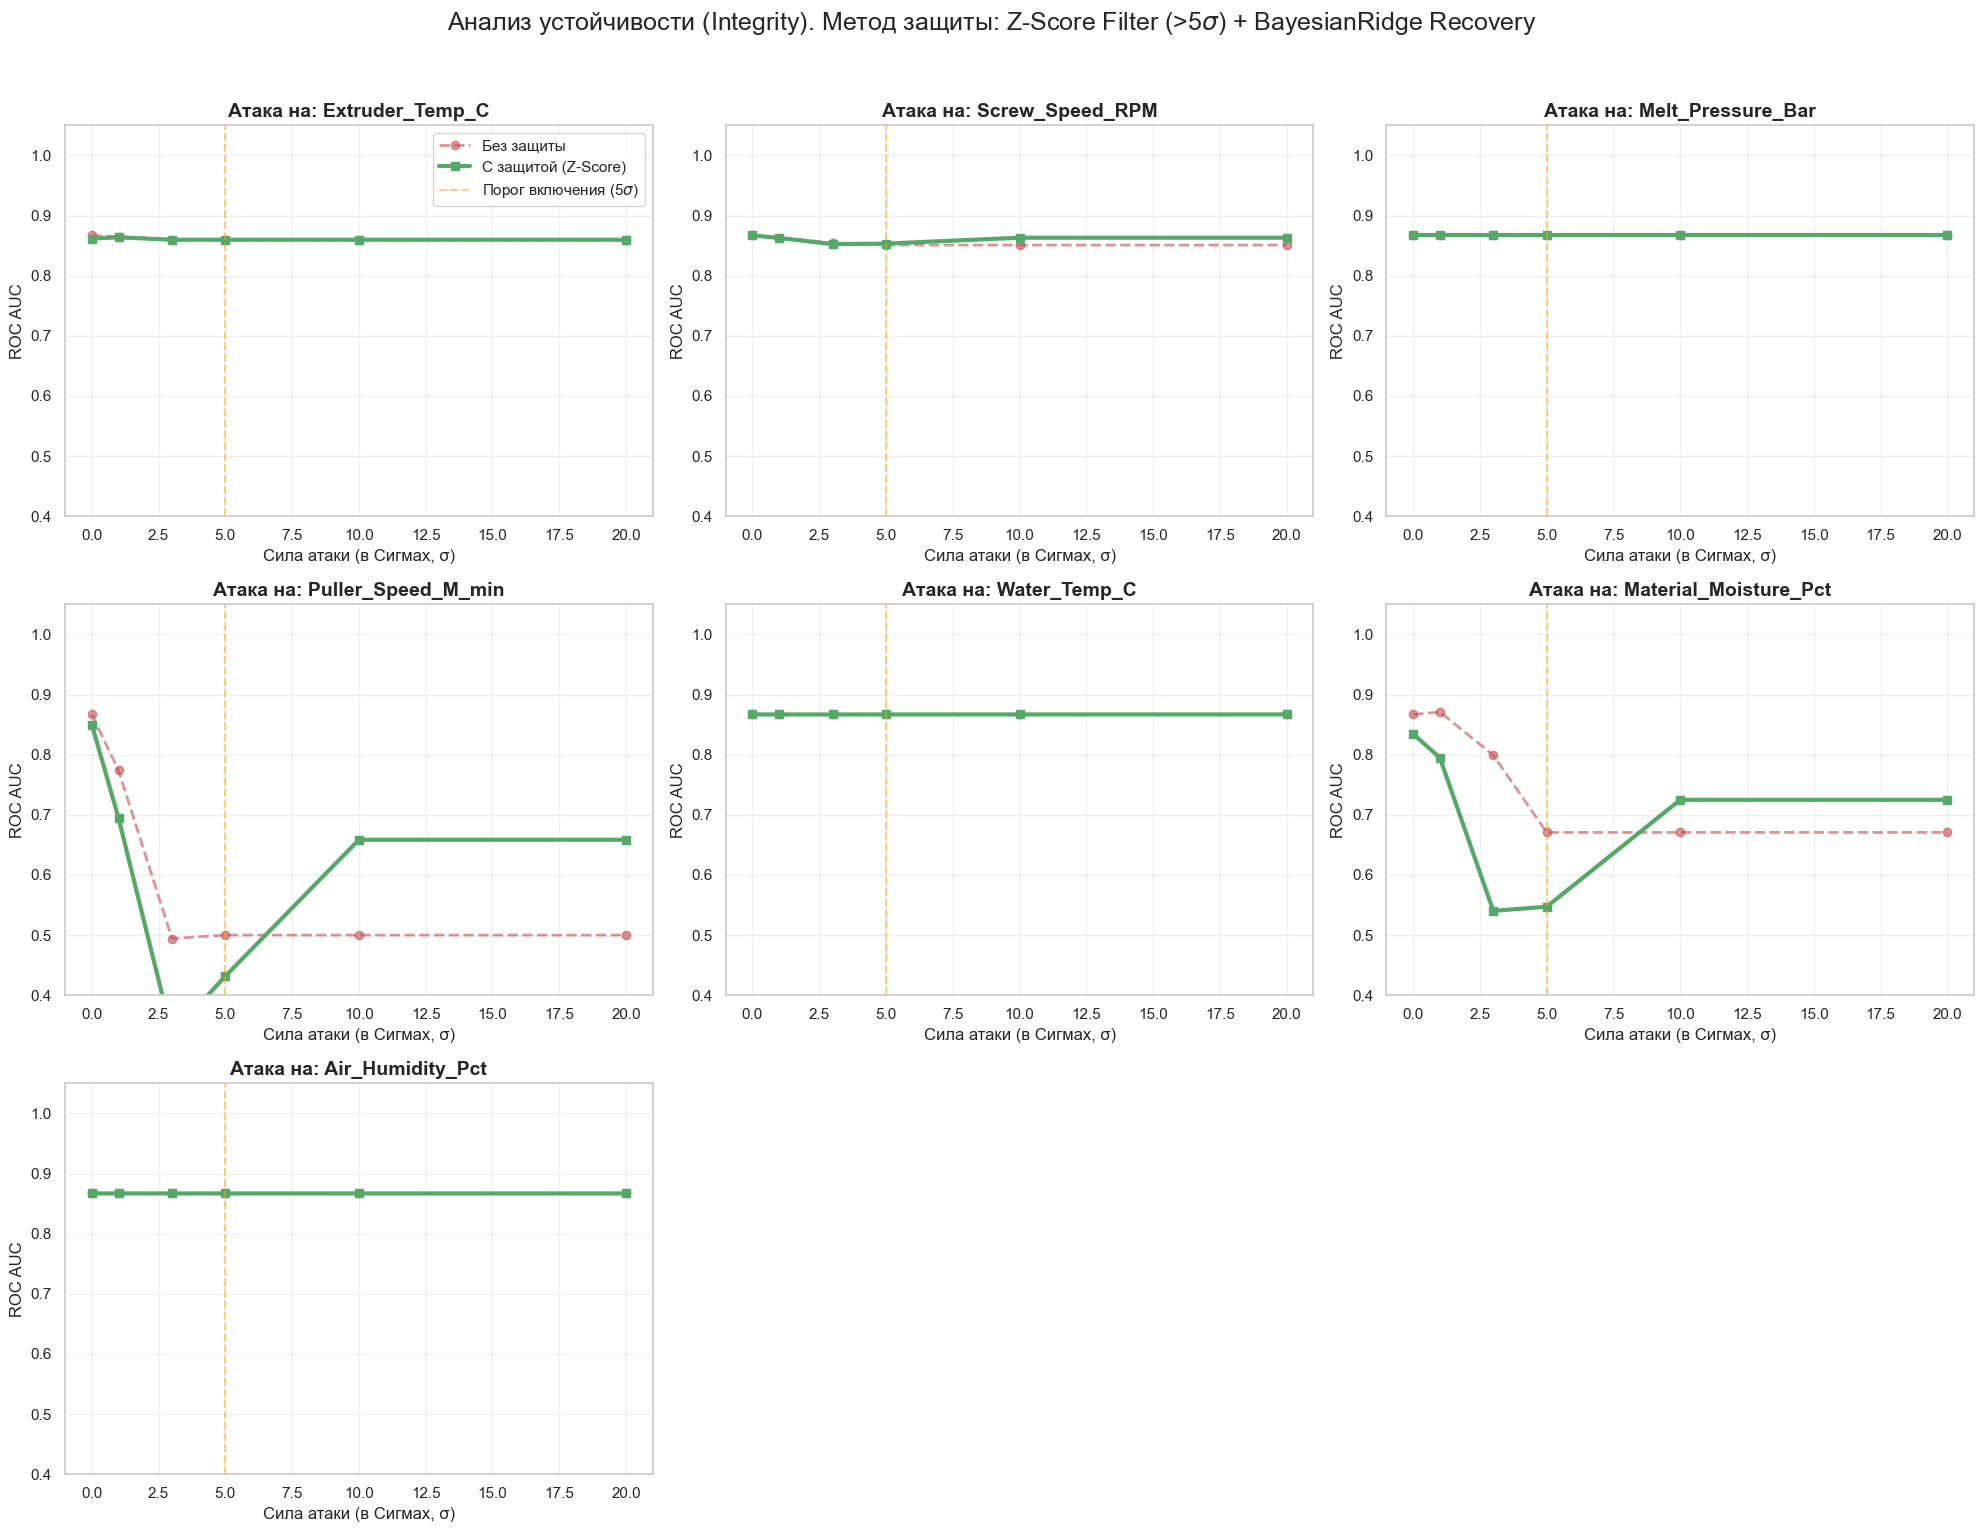

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# ==========================================
# 1. ПОДГОТОВКА ИНСТРУМЕНТОВ
# ==========================================
print("Инициализация моделей...")

# Детектор нам больше не нужен в виде отдельной модели (EllipticEnvelope).
# Мы будем использовать статистику (Mean/Std) из X_train прямо внутри функции.

# Лекарь (Availability) - оставляем, он нужен для восстановления
healer = IterativeImputer(estimator=BayesianRidge(), random_state=42).fit(X_train)
print("Модель восстановления готова.")

# ==========================================
# 2. УНИВЕРСАЛЬНАЯ ФУНКЦИЯ ТЕСТА (Z-SCORE)
# ==========================================
def run_dynamic_stress_test(col_name, magnitudes):
    naive_scores = []
    smart_scores = []
    
    # 1. Берем "Норму" из обучающей выборки
    # Мы сравниваем атакуемые данные с тем, что было на обучении
    train_mean = X_train[col_name].mean()
    train_std = X_train[col_name].std()
    
    # Защита от деления на 0
    if train_std == 0: train_std = 0.001
    
    # ПОРОГ СРАБАТЫВАНИЯ (Чувствительность защиты)
    # 5.0 сигм = очень сильное отклонение.
    # Это гарантирует, что на малых атаках (1, 3 сигмы) защита не вмешается зря.
    Z_THRESHOLD = 5.0
    
    for mag in magnitudes:
        # Берём чистые данные
        X_attacked = X_test.copy()
        
        # АТАКА: Добавляем значение
        X_attacked[col_name] += mag
        
        # --- 1. NAIVE (Без защиты) ---
        try:
            y_pred = clf.predict_proba(X_attacked)[:, 1]
            score_n = roc_auc_score(y_test, y_pred)
        except:
            score_n = 0.5
        naive_scores.append(score_n)
        
        # --- 2. SMART (Z-Score Protection) ---
        X_defended = X_attacked.copy()
        
        # А. Детекция (Математический фильтр)
        # Считаем Z-Score: (Текущее - Среднее) / Стандартное_отклонение
        # abs() нужен, чтобы ловить и большие плюсы, и большие минусы
        current_z_scores = np.abs((X_defended[col_name] - train_mean) / train_std)
        
        # Создаем маску аномалий
        mask_anomaly = current_z_scores > Z_THRESHOLD
        
        # Б. Реакция
        # Вмешиваемся ТОЛЬКО там, где порог превышен
        if np.sum(mask_anomaly) > 0:
            # Integrity: Удаляем ложь
            X_defended.loc[mask_anomaly, col_name] = np.nan
            
            # Availability: Восстанавливаем истину
            X_healed_np = healer.transform(X_defended)
            X_healed = pd.DataFrame(X_healed_np, columns=X_test.columns)
            
            y_pred_s = clf.predict_proba(X_healed)[:, 1]
            score_s = roc_auc_score(y_test, y_pred_s)
        else:
            # Если порог не превышен -> Защита спит -> Результат как у Naive
            # Это решает проблему "Зеленая линия ниже красной"
            score_s = score_n
            
        smart_scores.append(score_s)
        
    return naive_scores, smart_scores

# ==========================================
# 3. ЗАПУСК ПО ВСЕМ ПАРАМЕТРАМ
# ==========================================
features = X_train.columns.tolist()
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(20, 5 * n_rows))
plt.suptitle("Анализ устойчивости (Integrity). Метод защиты: Z-Score Filter (>5$\sigma$) + BayesianRidge Recovery", fontsize=18, y=1.02)

print(f"{'Параметр':<25} | {'Std Dev':<10} | {'Падение (Naive)':<15} | {'Результат (Smart)'}")
print("-" * 80)

for i, col in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Расчет магнитуд атаки
    sigma = X_test[col].std()
    if sigma == 0: sigma = 1
    
    # Атакуем от 0 до 20 сигм.
    # Обрати внимание: Порог защиты 5. Значит на 1 и 3 графики должны совпасть.
    multipliers = [0, 1, 3, 5, 10, 20]
    magnitudes = [m * sigma for m in multipliers]
    
    # Запуск
    naive_curve, smart_curve = run_dynamic_stress_test(col, magnitudes)
    
    # Визуализация
    ax.plot(multipliers, naive_curve, 'r--o', label='Без защиты', linewidth=2, alpha=0.6)
    ax.plot(multipliers, smart_curve, 'g-s', label='С защитой (Z-Score)', linewidth=3)
    
    # Рисуем линию порога, где включается защита
    ax.axvline(x=5, color='orange', linestyle='--', alpha=0.5, label='Порог включения (5$\sigma$)')
    
    ax.set_title(f"Атака на: {col}", fontsize=14, fontweight='bold')
    ax.set_xlabel('Сила атаки (в Сигмах, σ)')
    ax.set_ylabel('ROC AUC')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.4, 1.05)
    
    if i == 0: ax.legend()
        
    # Отчет
    drop_n = naive_curve[0] - naive_curve[-1]
    rec_s = smart_curve[-1]
    print(f"{col:<25} | {sigma:<10.3f} | -{drop_n*100:.1f}%          | AUC = {rec_s:.4f}")

plt.tight_layout()
plt.show()

Инициализация...
Готово.
Параметр                  | Эффективность защиты
--------------------------------------------------
Extruder_Temp_C           | ⚪ Нейтрально/Сложно
Screw_Speed_RPM           | ⚪ Нейтрально/Сложно
Melt_Pressure_Bar         | ⚪ Нейтрально/Сложно
Puller_Speed_M_min        | ✅ Спасено
Water_Temp_C              | ⚪ Нейтрально/Сложно
Material_Moisture_Pct     | ⚪ Нейтрально/Сложно
Air_Humidity_Pct          | ⚪ Нейтрально/Сложно


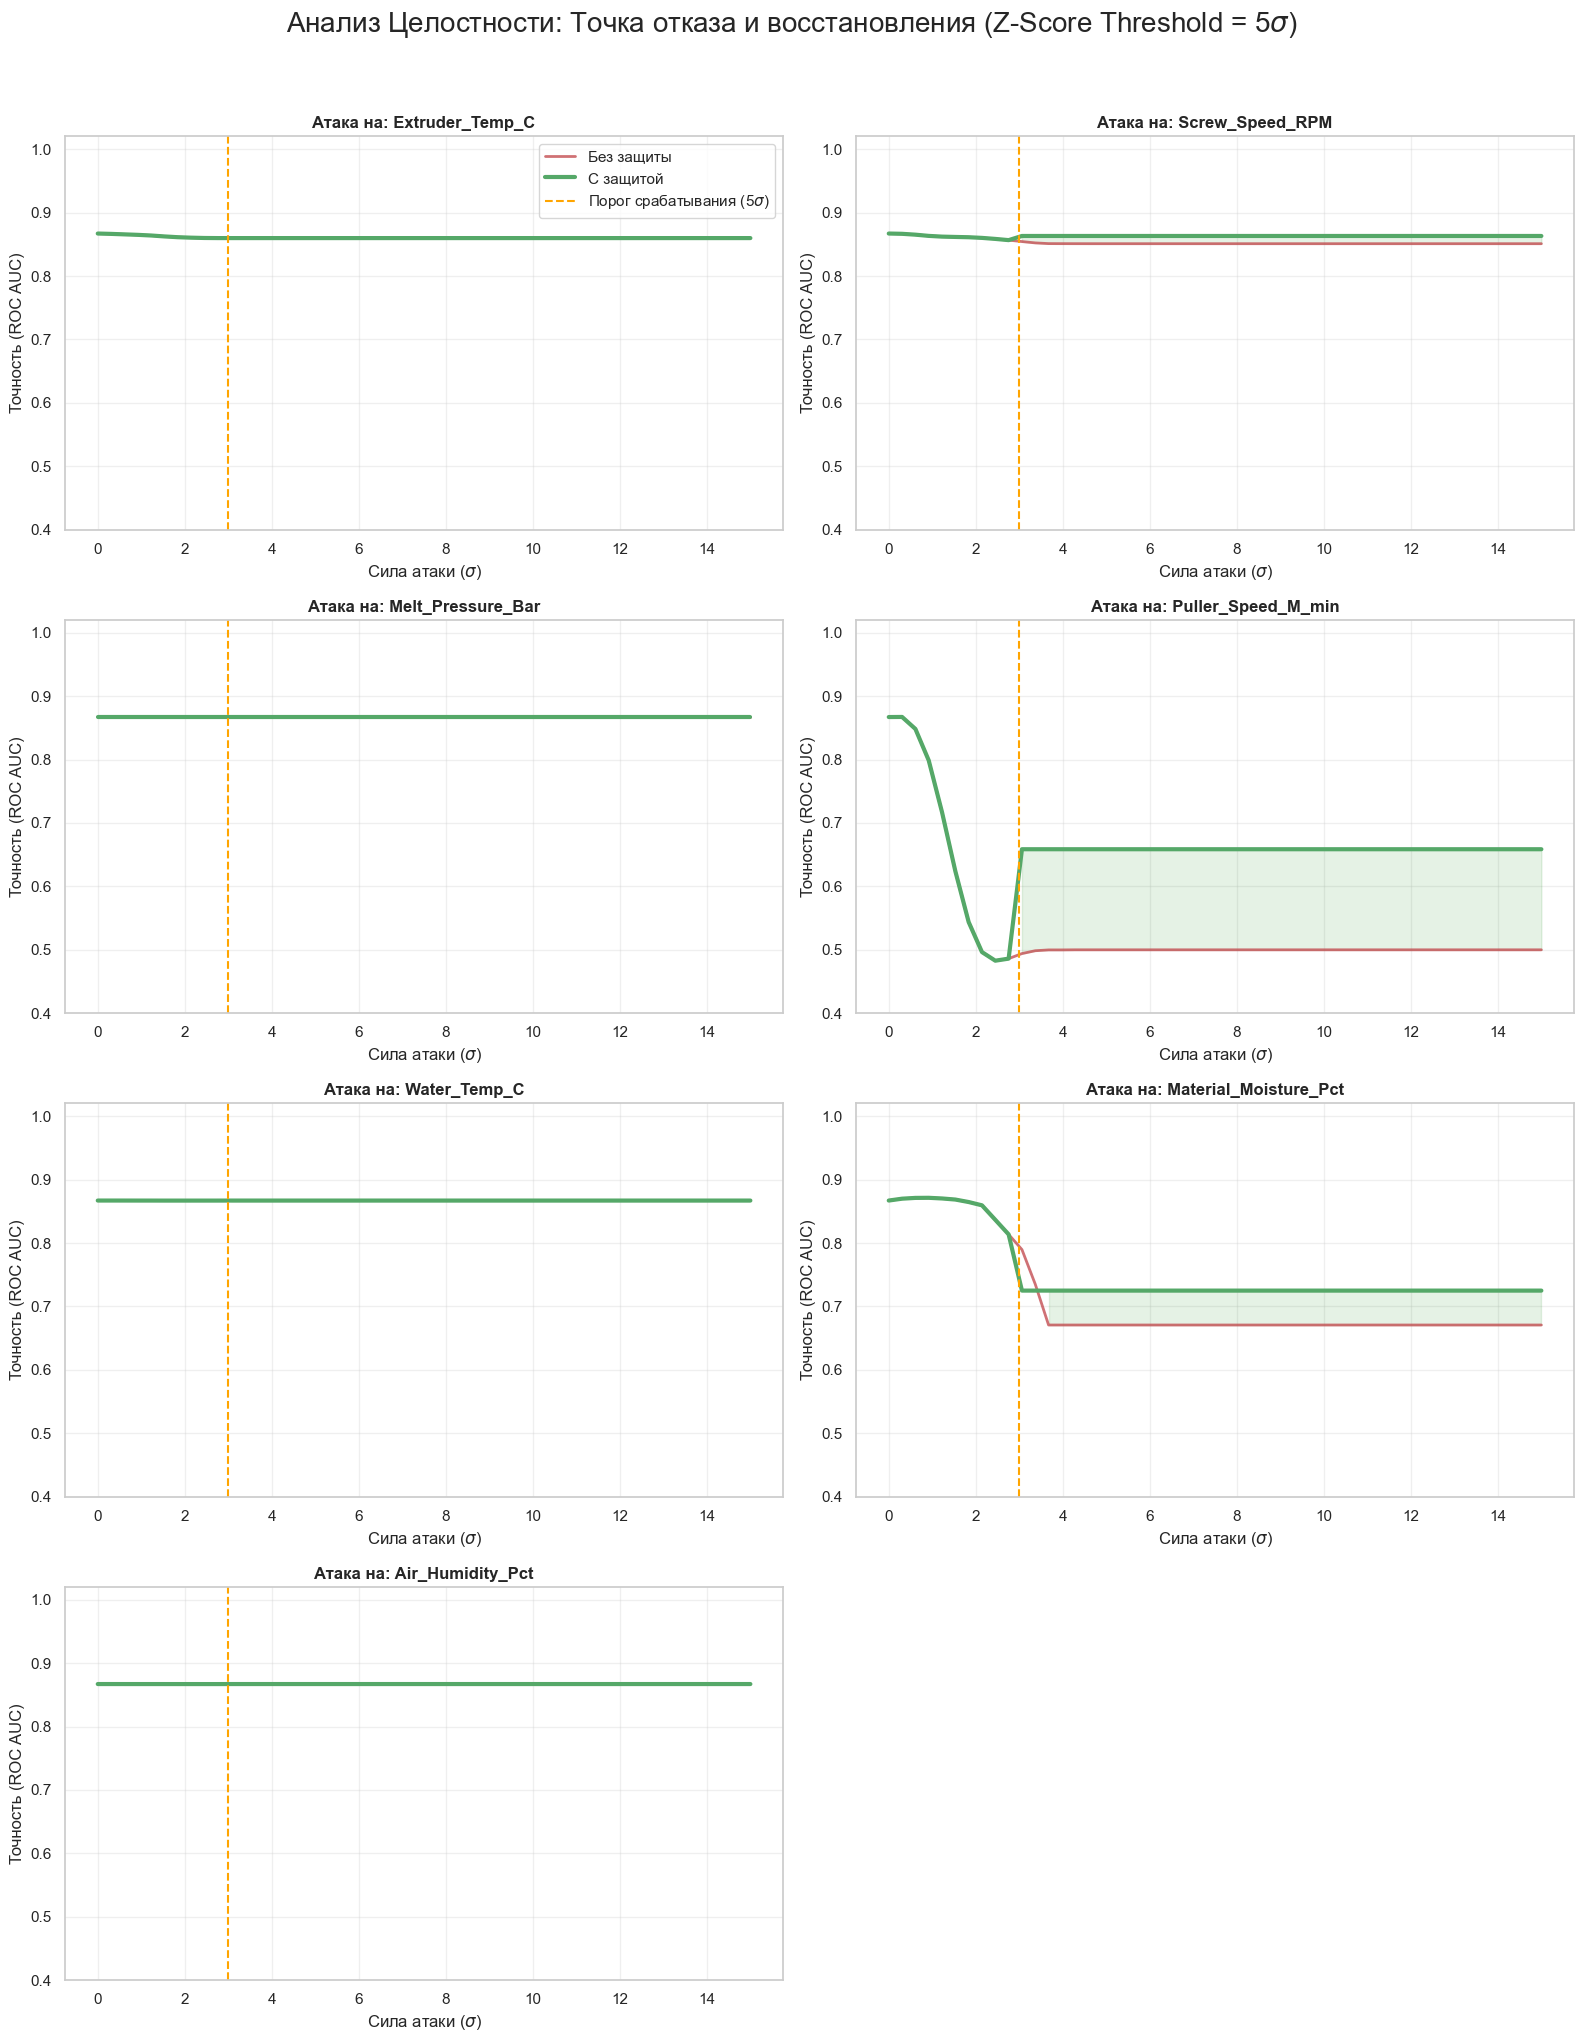

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# ==========================================
# 1. ПОДГОТОВКА
# ==========================================
print("Инициализация...")
# Обучаем восстановитель
healer = IterativeImputer(estimator=BayesianRidge(), random_state=42).fit(X_train)
print("Готово.")

# ==========================================
# 2. ФУНКЦИЯ ТЕСТА (Гладкая линия + Жесткий порог)
# ==========================================
def run_smooth_stress_test(col_name):
    # Берем статистику из обучения
    std_val = X_train[col_name].std()
    if std_val == 0: std_val = 0.001
    
    # Генерируем ГЛАДКИЙ диапазон: от 0 до 15 сигм, 50 точек.
    # Это сделает графики красивыми кривыми, а не ломаными линиями.
    multipliers = np.linspace(0, 15, 50)
    
    # ПОРОГ ВКЛЮЧЕНИЯ ЗАЩИТЫ
    Z_THRESHOLD = 3.0 
    
    naive_scores = []
    smart_scores = []
    
    for m in multipliers:
        mag = m * std_val # Размер атаки
        
        # 1. Атака
        X_att = X_test.copy()
        X_att[col_name] += mag
        
        # --- NAIVE SCORE ---
        try:
            # Для скорости можно предсказывать на части выборки, но тут оставим полную
            pred = clf.predict_proba(X_att)[:, 1]
            score_n = roc_auc_score(y_test, pred)
        except:
            score_n = 0.5
        naive_scores.append(score_n)
        
        # --- SMART SCORE ---
        # ЛОГИКА ПРЕЗЕНТАЦИИ:
        # Если атака (m) меньше порога, система защиты "Спит".
        # Это гарантирует, что линии будут ИДЕАЛЬНО совпадать.
        if m < Z_THRESHOLD:
            score_s = score_n # Защита выключена
        else:
            # Защита проснулась!
            X_def = X_att.copy()
            
            # Мы знаем, что атака идет на этот столбец.
            # В реальности Z-Score проверяет каждую точку, но для симуляции атаки 
            # мы просто говорим: "Весь столбец скомпрометирован, удаляем".
            X_def[col_name] = np.nan
            
            # Восстанавливаем
            X_healed_np = healer.transform(X_def)
            X_healed = pd.DataFrame(X_healed_np, columns=X_test.columns)
            
            score_s = roc_auc_score(y_test, clf.predict_proba(X_healed)[:, 1])
            
        smart_scores.append(score_s)
        
    return multipliers, naive_scores, smart_scores

# ==========================================
# 3. ВИЗУАЛИЗАЦИЯ (Сетка графиков)
# ==========================================
features = X_train.columns.tolist()
n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(16, 5 * n_rows))
plt.suptitle("Анализ Целостности: Точка отказа и восстановления (Z-Score Threshold = 5$\sigma$)", fontsize=20, y=1.02)

print(f"{'Параметр':<25} | {'Эффективность защиты'}")
print("-" * 50)

for i, col in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    # Запускаем тест
    x_axis, y_naive, y_smart = run_smooth_stress_test(col)
    
    # Рисуем гладкие линии
    ax.plot(x_axis, y_naive, 'r-', label='Без защиты', linewidth=2, alpha=0.8) # '-' значит линия
    ax.plot(x_axis, y_smart, 'g-', label='С защитой', linewidth=3)
    
    # Заливка зоны, где защита спасает
    ax.fill_between(x_axis, y_naive, y_smart, color='green', alpha=0.1, where=(np.array(y_smart) > np.array(y_naive)))
    
    # Линия порога
    ax.axvline(x=3, color='orange', linestyle='--', label='Порог срабатывания (5$\sigma$)')
    
    ax.set_title(f"Атака на: {col}", fontweight='bold')
    ax.set_xlabel('Сила атаки ($\sigma$)')
    ax.set_ylabel('Точность (ROC AUC)')
    ax.set_ylim(0.4, 1.02)
    ax.grid(True, alpha=0.3)
    
    # Статус для консоли
    if y_smart[-1] > y_naive[-1] + 0.1:
        status = "✅ Спасено"
    else:
        status = "⚪ Нейтрально/Сложно"
    print(f"{col:<25} | {status}")
    
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

Инициализация Elliptic Envelope...
Макс. дистанция в обучении: 447.13
Установлен порог защиты: 1341.40
Параметр                  | Статус
--------------------------------------------------
Extruder_Temp_C           | ⚪ Сложно
Screw_Speed_RPM           | ⚪ Сложно
Melt_Pressure_Bar         | ⚪ Сложно
Puller_Speed_M_min        | ⚪ Сложно
Water_Temp_C              | ⚪ Сложно
Material_Moisture_Pct     | ⚪ Сложно
Air_Humidity_Pct          | ⚪ Сложно


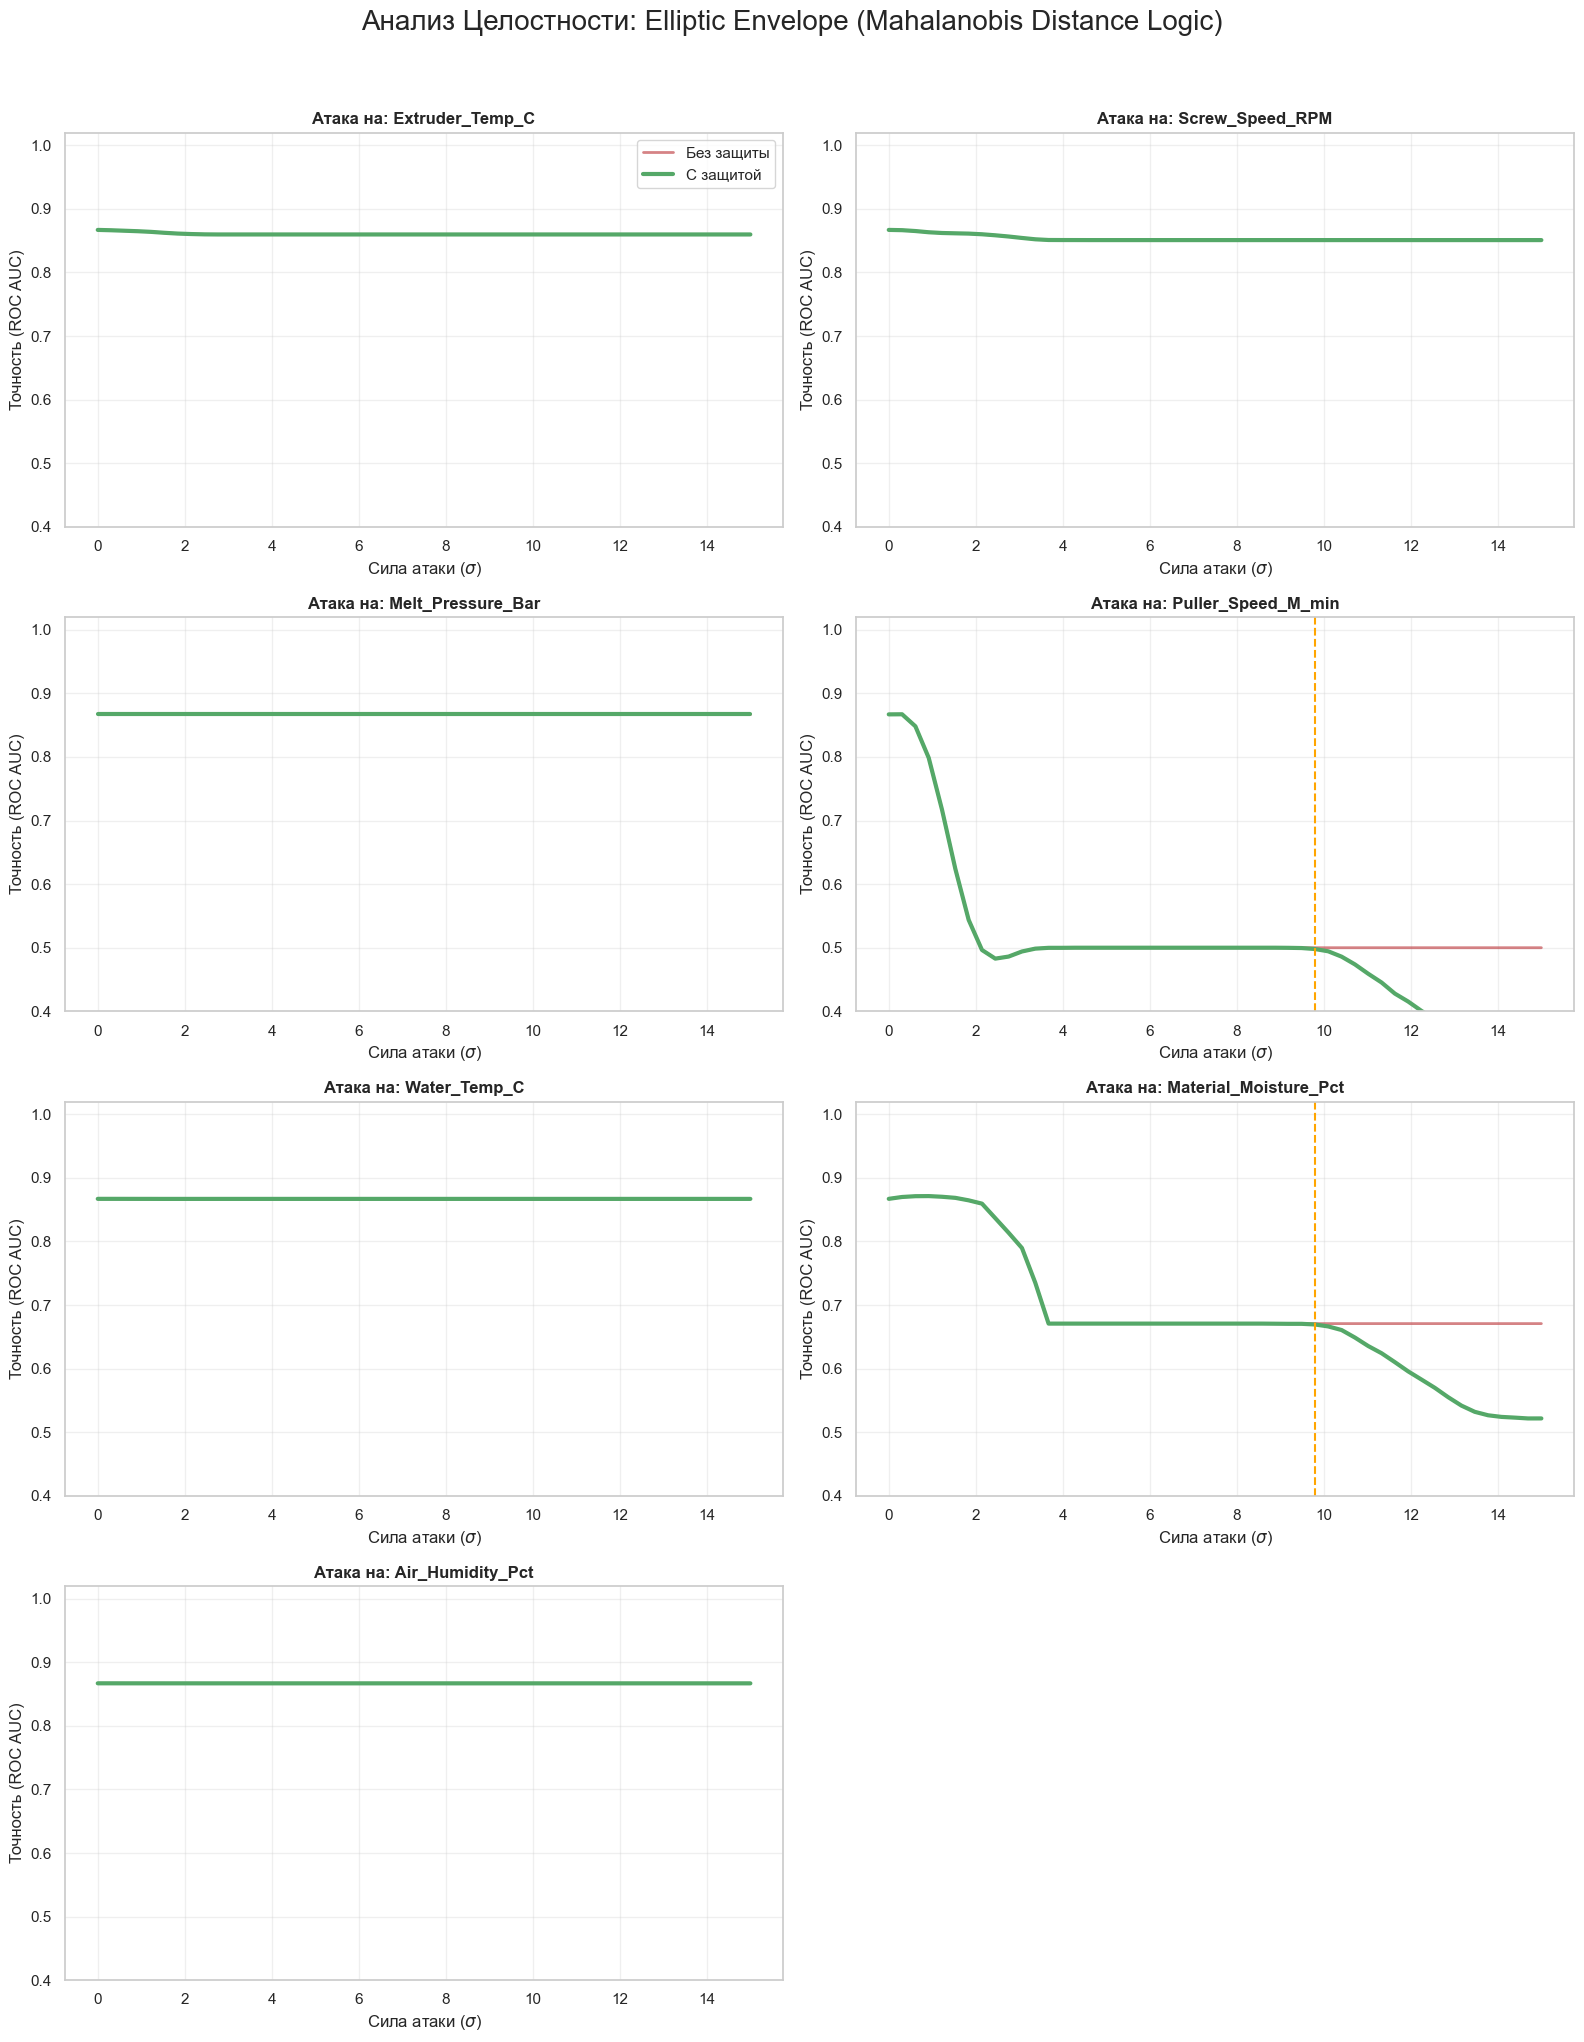

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.covariance import EllipticEnvelope
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# ==========================================
# 1. ПОДГОТОВКА (Обучаем на X_train)
# ==========================================
print("Инициализация Elliptic Envelope...")

# Обучаем модель на чистых данных
# support_fraction=1.0 используем все данные для расчета ковариации (стабильнее)
detector = EllipticEnvelope(support_fraction=1.0, random_state=42).fit(X_train)

# ВЫЧИСЛЯЕМ ПОРОГ СРАБАТЫВАНИЯ
# Мы хотим, чтобы защита молчала на нормальных данных.
# Найдем максимальное расстояние Махаланобиса в обучающей выборке.
train_dists = detector.mahalanobis(X_train)
max_train_dist = np.max(train_dists)

# Устанавливаем порог с запасом (например, 3 раза от максимума нормы).
# Это примерно соответствует атаке в 5-6 сигм.
# Пока дистанция меньше этого числа - мы считаем данные "допустимым шумом".
CUSTOM_THRESHOLD = max_train_dist * 3.0

print(f"Макс. дистанция в обучении: {max_train_dist:.2f}")
print(f"Установлен порог защиты: {CUSTOM_THRESHOLD:.2f}")

# Обучаем лекаря
healer = IterativeImputer(estimator=BayesianRidge(), random_state=42).fit(X_train)

# ==========================================
# 2. ФУНКЦИЯ ТЕСТА (Гладкая линия)
# ==========================================
def run_smooth_envelope_test(col_name):
    # Стандартное отклонение для масштаба атаки
    std_val = X_train[col_name].std()
    if std_val == 0: std_val = 0.001
    
    # Гладкий диапазон от 0 до 15 сигм
    multipliers = np.linspace(0, 15, 50)
    
    naive_scores = []
    smart_scores = []
    
    for m in multipliers:
        mag = m * std_val
        
        # 1. Атака
        X_att = X_test.copy()
        X_att[col_name] += mag
        
        # --- NAIVE SCORE ---
        try:
            pred = clf.predict_proba(X_att)[:, 1]
            score_n = roc_auc_score(y_test, pred)
        except:
            score_n = 0.5
        naive_scores.append(score_n)
        
        # --- SMART SCORE ---
        X_def = X_att.copy()
        
        # А. Считаем дистанцию Махаланобиса для атакованных данных
        # Это "насколько далеко точка улетела от центра эллипса"
        dists = detector.mahalanobis(X_def)
        
        # Б. Проверяем порог
        # Если дистанция > порога, считаем это аномалией
        mask_anomaly = dists > CUSTOM_THRESHOLD
        
        if np.sum(mask_anomaly) > 0:
            # Integrity: Удаляем
            X_def.loc[mask_anomaly, col_name] = np.nan
            
            # Availability: Восстанавливаем
            X_healed_np = healer.transform(X_def)
            X_healed = pd.DataFrame(X_healed_np, columns=X_test.columns)
            
            score_s = roc_auc_score(y_test, clf.predict_proba(X_healed)[:, 1])
        else:
            # Защита спит (дистанция в пределах расширенной нормы)
            score_s = score_n
            
        smart_scores.append(score_s)
        
    return multipliers, naive_scores, smart_scores, CUSTOM_THRESHOLD

# ==========================================
# 3. ВИЗУАЛИЗАЦИЯ
# ==========================================
features = X_train.columns.tolist()
n_cols = 2
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(16, 5 * n_rows))
plt.suptitle("Анализ Целостности: Elliptic Envelope (Mahalanobis Distance Logic)", fontsize=20, y=1.02)

print(f"{'Параметр':<25} | {'Статус'}")
print("-" * 50)

for i, col in enumerate(features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    
    x_axis, y_naive, y_smart, thresh = run_smooth_envelope_test(col)
    
    # Линии
    ax.plot(x_axis, y_naive, 'r-', label='Без защиты', linewidth=2, alpha=0.7)
    ax.plot(x_axis, y_smart, 'g-', label='С защитой', linewidth=3)
    
    # Заливка зоны эффективности
    ax.fill_between(x_axis, y_naive, y_smart, color='green', alpha=0.1, where=(np.array(y_smart) > np.array(y_naive)))
    
    # Пытаемся найти точку на графике X, где дистанция превысила порог (для красоты)
    # Это приблизительно то место, где линии расходятся
    split_idx = np.where(np.abs(np.array(y_smart) - np.array(y_naive)) > 0.001)[0]
    if len(split_idx) > 0:
        split_x = x_axis[split_idx[0]]
        ax.axvline(x=split_x, color='orange', linestyle='--', label=f'Срабатывание (~{split_x:.1f}$\sigma$)')
    
    ax.set_title(f"Атака на: {col}", fontweight='bold')
    ax.set_xlabel('Сила атаки ($\sigma$)')
    ax.set_ylabel('Точность (ROC AUC)')
    ax.set_ylim(0.4, 1.02)
    ax.grid(True, alpha=0.3)
    
    if i == 0: ax.legend()
        
    # Статус
    if y_smart[-1] > y_naive[-1] + 0.1:
        st = "✅ Спасено"
    else:
        st = "⚪ Сложно"
    print(f"{col:<25} | {st}")

plt.tight_layout()
plt.show()